# Importing Data & Packages

In [1]:
# General purpose libraries
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Deep learning library
import keras 
from keras import layers

print('Everything Imported Succesfully!')

Everything Imported Succesfully!


In [2]:
data=pd.read_csv('/kaggle/input/301-330-days/Data_5IAL_3_301.csv',index_col=0,parse_dates=[1])  # Read data
data.rename(columns={'0':'Date'},inplace=True)                                                  # Give date column a descriptive name
data['5IAL_3_301.BatchName']=data['5IAL_3_301.BatchName'].fillna('No Batch Specified')          # Replace batchnames NaN's with 'no batch'
data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Date  5IAL_3_TT301.50  5IAL_3_QIT301.52  5IAL_3_PIT 301.55  \
0 2022-04-10 12:00:00            21.80              9.84              -0.02   
1 2022-04-10 12:01:00            21.80              9.84              -0.02   
2 2022-04-10 12:02:00            21.80              9.84              -0.02   
3 2022-04-10 12:03:00            21.78              9.84              -0.02   
4 2022-04-10 12:04:00            21.78              9.84              -0.02   

   5IAL_3_QIT301.57  5IAL_3_PIT301.60  5IAL_3_FIT301.61MF  5IAL_3_FIT301.61VF  \
0               0.0               0.0                 0.0                 0.0   
1               0.0               0.0                 0.0                 0.0   
2               0.0               0.0                 0.0                 0.0   
3               0.0               0.0                 0.0                 0.0   
4               0.0               0.0                 0.0                 0.0   

   5IAL_3_FIT301.61D  5IAL_3_PIT301.63  ...  5IAL_3_GSC301.44  \
0            0.00105              2.07  ...                 0   
1            0.00106              2.07  ...                 0   
2            0.00102              2.07  ...                 0   
3            0.00105              2.07  ...                 0   
4            0.00104              2.07  ...                 0   

   5IAL_3_GSO301.44  5IAL_3_LSL301.64 5IAL_3_LSL301.68  5IAL_3_LSLL301.69  \
0                 0                 0                0                  0   
1                 0                 0                0                  0   
2                 0                 0                0                  0   
3                 0                 0                0                  0   
4                 0                 0                0                  0   

   5IAL_3_301.OCCUPIED  5IAL_3_LIT301.54  5IAL_3_LSH301.56  5IAL_3_XPV301.13  \
0                    0              1.40                 0               0.0   
1                    0              1.40                 0               0.0   
2                    0              1.41                 0               0.0   
3                    0              1.40                 0               0.0   
4                    0              1.40                 0               0.0   

   5IAL_3_WY301.54  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  

[5 rows x 39 columns]

In [3]:
pd_data=(data['5IAL_3_301.BatchName']=='KD112304006')

#print(np.sum(pd_data))
print(pd_data[pd_data].index)

print(data['Date'][439158])

Int64Index([439158, 439159, 439160, 439161, 439162, 439163, 439164, 439165,
            439166, 439167,
            ...
            439400, 439401, 439402, 439403, 439404, 439405, 439406, 439407,
            439408, 439409],
           dtype='int64', length=252)
2023-02-09 11:18:00


# Data Splitting and Grouping 

In [4]:
Batch_Names=data['5IAL_3_301.BatchName']
unique_names=Batch_Names.unique()
print(unique_names)

['No Batch Specified' 'YP5812210101' 'YP5812210102' ... 'KB212306501'
 'NA KB212306501' 'KC112306501']


In [5]:
print(unique_names.size)

1629


## Filter out the batches
In this step everything that is not a viable batch is filterd out.\
This way demi cleanings, CIP cleanings and downtime are no longer in the dataset.

In [6]:
#Convert the unique_names numpy array to a pandas series
temp_df=pd.Series(unique_names)

# Create a boolean mask to select rows where the length of the specified column is between 11 and 12 characters (inclusive)
mask = (temp_df.str.len() >= 11) & (temp_df.str.len() <= 12)

# Use the boolean mask to select only the rows that meet the criteria
Viable_Batches = unique_names[mask]

print(Viable_Batches.size)

del temp_df

1205


## Train Test Split

Randomly pick the Test_Train_split fraction of data from the filterd unique name list.\
This way a percentage of batches are not used in training and thus can be used for testing.

In [7]:
To_split=Viable_Batches
Test_Train_split=0.2

Test_Batches=random.sample(To_split.tolist(), round(To_split.size*Test_Train_split))

Train_Batches = [x for x in To_split if x not in Test_Batches]

print(len(Test_Batches))
print(len(Train_Batches))

241
964


In [8]:
# Use 'isin' to only select datapoint that have a batch name that was selected by the Test_Train split
Train_Data=data[data['5IAL_3_301.BatchName'].isin(Train_Batches)]
Test_Data=data[data['5IAL_3_301.BatchName'].isin(Test_Batches)]

## Normalise the selection with use of the Z-Score
The Z-score can be described as:\
$Z=\frac{x-\mu}{\sigma}$

In this x is your value, μ is the average of the population that value is taken from, and σ is the standard deviation of the population. It is basicaly a measure of how far a given value is away from its mean in standard deviations. To give you a good feeling, in a normal distribution 66% of values are within 1 std of the mean. 99% are withing 2 std and 99.9 is within 3

Note that the data does not represent a normal curve or bell curve at all. This is solely done to make sure the Neural network gives every value an equeal weigth.\

Also drop everything that turns into NaN's when normalizing

In [9]:
names=Train_Data['5IAL_3_301.BatchName']

col_2_drop=['Date','5IAL_3_301.BatchName','5IAL_3_LSH301.56','5IAL_3_XPV301.05','5IAL_3_XPV301.06','5IAL_3_XPV301.08','5IAL_3_XPV301.09','5IAL_3_XPV301.22','5IAL_3_XPV301.36','5IAL_3_XPV301.42','5IAL_3_XPV301.43','5IAL_3_XPV301.46','5IAL_3_LSL301.64','5IAL_3_XPV301.35']
df=Train_Data.drop(col_2_drop,axis=1)

data_norm=(df-df.mean())/df.std()

data_norm=pd.concat([data_norm,names],axis=1)

# Will need these values to normalise Test data in the same way as Train data
data_norm_values=pd.DataFrame()
for col in df:
    data_norm_values[col]=[np.mean(df[col]),np.std(df[col])]
    

In [10]:
data_norm_values=data_norm_values.rename(index={0:'mean', 1:'std'})
#data_norm.head()
#data_norm.isna().sum()
data_norm_values.head()

5IAL_3_TT301.50  5IAL_3_QIT301.52  5IAL_3_PIT 301.55  5IAL_3_QIT301.57  \
mean        27.573902          8.775535           0.486328       3404.613341   
std          2.869694          1.322937           0.352665      11364.302643   

      5IAL_3_PIT301.60  5IAL_3_FIT301.61MF  5IAL_3_FIT301.61VF  \
mean          0.000117          100.887142           11.029640   
std           0.001321           64.423407          491.606665   

      5IAL_3_FIT301.61D  5IAL_3_PIT301.63  5IAL_3_P301.70  ...  \
mean           0.988536          2.173508        1.435426  ...   
std            0.303382          0.120480        0.897815  ...   

      5IAL_3_LSL301.51  5IAL_3_LSL301.53  5IAL_3_GSC301.44  5IAL_3_GSO301.44  \
mean          0.085701          0.082055          0.916878          0.083034   
std           0.279922          0.274449          0.276067          0.275933   

      5IAL_3_LSL301.68  5IAL_3_LSLL301.69  5IAL_3_301.OCCUPIED  \
mean          0.010266           0.000930             0.996807   
std           0.100800           0.030475             0.056416   

      5IAL_3_LIT301.54  5IAL_3_XPV301.13  5IAL_3_WY301.54  
mean         67.238736          1.433971      1367.461412  
std          32.268568          0.897017       645.833689  

[2 rows x 25 columns]

## Normalizing the test data with train values

In [11]:
names=Test_Data['5IAL_3_301.BatchName']
col_2_drop=['Date','5IAL_3_301.BatchName','5IAL_3_LSH301.56','5IAL_3_XPV301.05','5IAL_3_XPV301.06','5IAL_3_XPV301.08','5IAL_3_XPV301.09','5IAL_3_XPV301.22','5IAL_3_XPV301.36','5IAL_3_XPV301.42','5IAL_3_XPV301.43','5IAL_3_XPV301.46','5IAL_3_LSL301.64','5IAL_3_XPV301.35']
df=Test_Data.drop(col_2_drop,axis=1)

Test_Data_Norm=pd.DataFrame()

for col in df:
    Test_Data_Norm[col]=(df[col]-data_norm_values[col][0])/data_norm_values[col][1]
    
Test_Data_Norm=pd.concat([Test_Data_Norm,names],axis=1)
Test_Data_Norm.head()    

5IAL_3_TT301.50  5IAL_3_QIT301.52  5IAL_3_PIT 301.55  5IAL_3_QIT301.57  \
1169        -2.029451          0.978478          -1.435719         -0.299588   
1170        -0.593757          0.978478          -1.435719         -0.299588   
1171        -0.614666          0.849976           1.683385         -0.287850   
1172        -0.475278          0.865094           1.711740         -0.284822   
1173        -0.255742          0.993596           0.407388         -0.283098   

      5IAL_3_PIT301.60  5IAL_3_FIT301.61MF  5IAL_3_FIT301.61VF  \
1169         -0.088559           -1.566001           -0.022436   
1170          7.482688           -1.566001           -0.022436   
1171          7.482688            0.222324           -0.008746   
1172          7.482688            0.247470           -0.008522   
1173         -0.088559            0.749306           -0.004841   

      5IAL_3_FIT301.61D  5IAL_3_PIT301.63  5IAL_3_P301.70  ...  \
1169          -3.254167         -0.859126       -1.598800  ...   
1170          -3.254266         -0.859126       -1.598800  ...   
1171           0.127444         -0.859126        0.662245  ...   
1172           0.121841         -0.859126        0.651107  ...   
1173           0.150847         -0.859126        0.628831  ...   

      5IAL_3_LSL301.53  5IAL_3_GSC301.44  5IAL_3_GSO301.44  5IAL_3_LSL301.68  \
1169          3.344679         -3.321210          3.323149         -0.101846   
1170          3.344679         -3.321210          3.323149         -0.101846   
1171         -0.298982          0.301095         -0.300919         -0.101846   
1172         -0.298982          0.301095         -0.300919         -0.101846   
1173         -0.298982          0.301095         -0.300919         -0.101846   

      5IAL_3_LSLL301.69  5IAL_3_301.OCCUPIED  5IAL_3_LIT301.54  \
1169          -0.030504           -17.668824         -2.016474   
1170          -0.030504             0.056597         -1.878879   
1171          -0.030504             0.056597         -1.392028   
1172          -0.030504             0.056597         -1.088636   
1173          -0.030504             0.056597         -1.072522   

      5IAL_3_XPV301.13  5IAL_3_WY301.54  5IAL_3_301.BatchName  
1169         -1.598600        -2.117358          YP5812210101  
1170         -1.598600        -1.998721          YP5812210101  
1171          0.631013        -1.726685          YP5812210101  
1172          0.564125        -1.442711          YP5812210101  
1173          0.619865        -1.325576          YP5812210101  

[5 rows x 26 columns]

In [12]:
Train_Grouped=data_norm.groupby(["5IAL_3_301.BatchName"],as_index=True)
Test_Grouped=Test_Data_Norm.groupby(["5IAL_3_301.BatchName"],as_index=True)
                                 
Train_Grouped.size()
Test_Grouped.size()

5IAL_3_301.BatchName
CB212215401     111
CB212215402     113
CC112222901     131
CD112212403     117
CD112218501      87
               ... 
YP7012226502    112
YP7012231301     73
YP7012231302    210
YP7012231303     82
YP7012304802    142
Length: 241, dtype: int64

# Model defining & Training
## Define Keras Model
This model can be described as a deep convolutional Auto-encoder.

In [13]:
columns=25
batches=964

model = keras.Sequential(
    [
        layers.Input(shape=(columns,1,1)),
        layers.Conv2D(
            filters=32, kernel_size=8, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.1),
        layers.Conv2D(
            filters=16, kernel_size=16, padding="same", strides=1, activation="relu"
        ),
        layers.Conv2DTranspose(
            filters=16, kernel_size=16, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.1),
        layers.Conv2DTranspose(
            filters=32, kernel_size=8, padding="same", strides=1, activation="relu"
        ),
        layers.Conv2DTranspose(filters=1, kernel_size=6, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 1, 32)         2080      
                                                                 
 dropout (Dropout)           (None, 25, 1, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 1, 16)         131088    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 25, 1, 16)        65552     
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 25, 1, 16)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 25, 1, 32)        32800     
 ranspose)                                              

## Training the Autoencoder
Train the autoencoder on 1 batch of data at a time.
This is necceray for 2 reasons.
1. The data has variable lenghts, this cant be stored in a numpy array.
2. If you try to keep all values in memory at once, the RAM overflows and the kernel dies. This way that never happens

In [14]:
i=0
for row in Train_Batches:
    X_batch=Train_Grouped.get_group(row)
    X_batch=X_batch.drop(['5IAL_3_301.BatchName'],axis=1)
    X_batch=np.expand_dims(X_batch,axis=2)
    X_batch=np.expand_dims(X_batch,axis=3)
    history = model.fit(
        X_batch,
        X_batch,
        epochs=50,
        verbose=0,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )
    
    i=i+1
    
    # Show only the tenth itteration to avoid clutter, but keep an eye on progress
    if (i % 10)==9:
        progress='{} out of {} batches used for training'.format(i+1,batches)
        print(progress)

2023-04-07 09:37:20.407111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10 out of 964 batches used for training
20 out of 964 batches used for training
30 out of 964 batches used for training
40 out of 964 batches used for training
50 out of 964 batches used for training
60 out of 964 batches used for training
70 out of 964 batches used for training
80 out of 964 batches used for training
90 out of 964 batches used for training
100 out of 964 batches used for training
110 out of 964 batches used for training
120 out of 964 batches used for training
130 out of 964 batches used for training
140 out of 964 batches used for training
150 out of 964 batches used for training
160 out of 964 batches used for training
170 out of 964 batches used for training
180 out of 964 batches used for training
190 out of 964 batches used for training
200 out of 964 batches used for training
210 out of 964 batches used for training
220 out of 964 batches used for training
230 out of 964 batches used for training
240 out of 964 batches used for training
250 out of 964 batches us

In [15]:
print(data_norm.columns)

Index(['5IAL_3_TT301.50', '5IAL_3_QIT301.52', '5IAL_3_PIT 301.55',
       '5IAL_3_QIT301.57', '5IAL_3_PIT301.60', '5IAL_3_FIT301.61MF',
       '5IAL_3_FIT301.61VF', '5IAL_3_FIT301.61D', '5IAL_3_PIT301.63',
       '5IAL_3_P301.70', '5IAL_3_R301.71', '5IAL_3_P301.72',
       '5IAL_3_XPV301.53', '5IAL_3_XPV301.54', '5IAL_3_XPV301.63',
       '5IAL_3_LSL301.51', '5IAL_3_LSL301.53', '5IAL_3_GSC301.44',
       '5IAL_3_GSO301.44', '5IAL_3_LSL301.68', '5IAL_3_LSLL301.69',
       '5IAL_3_301.OCCUPIED', '5IAL_3_LIT301.54', '5IAL_3_XPV301.13',
       '5IAL_3_WY301.54', '5IAL_3_301.BatchName'],
      dtype='object')


# Get a random batch from the train set and display it here
everytime you run this cel it gets a random batch, be sure to run it a couple of times

3/3 [==============================] - 0s 3ms/step


Text(0.5, 1.0, '5IAL_3_PIT 301.55')

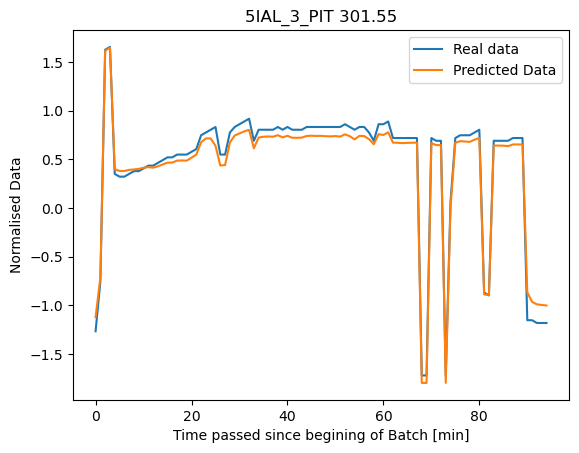

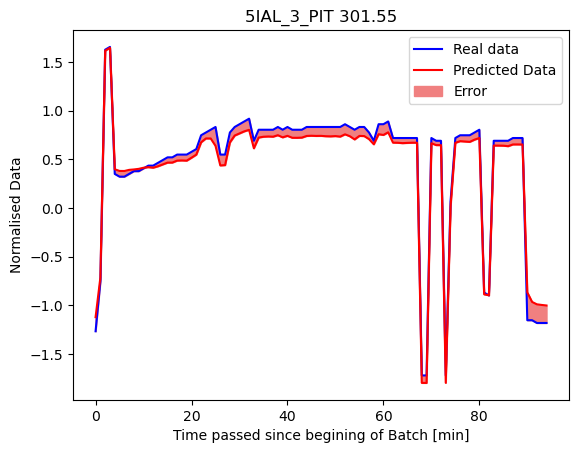

In [16]:
Random_Batch=Train_Grouped.get_group(random.sample(Train_Batches,1)[0])

Random_Batch=Random_Batch.drop(['5IAL_3_301.BatchName'],axis=1)
Random_Batch=np.expand_dims(Random_Batch,axis=2)
Random_Batch=np.expand_dims(Random_Batch,axis=3)


Random_Batch_Pred= model.predict(Random_Batch)

var=2

plt.plot(Random_Batch[:,var,0,0])
plt.plot(Random_Batch_Pred[:,var,0,0])
plt.legend(['Real data','Predicted Data'])
plt.xlabel('Time passed since begining of Batch [min]')
plt.ylabel('Normalised Data')
plt.title(data_norm.columns[var])
plt.figure()

plt.plot(Random_Batch[:,var,0,0],'b')
plt.plot(Random_Batch_Pred[:,var,0,0],'r')
plt.fill_between(np.arange(Random_Batch.shape[0]), Random_Batch_Pred[:,var,0,0], Random_Batch[:,var,0,0], color='lightcoral')
plt.legend(labels=['Real data','Predicted Data', "Error"])
plt.xlabel('Time passed since begining of Batch [min]')
plt.ylabel('Normalised Data')
plt.title(data_norm.columns[var])

## get random Test sample and display it here

4/4 [==============================] - 0s 3ms/step
0.09521641297383358


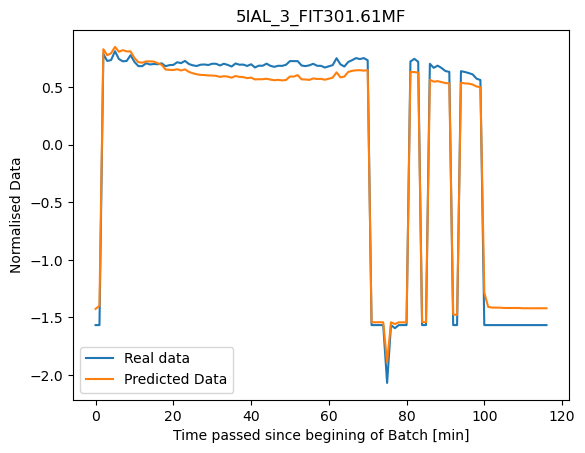

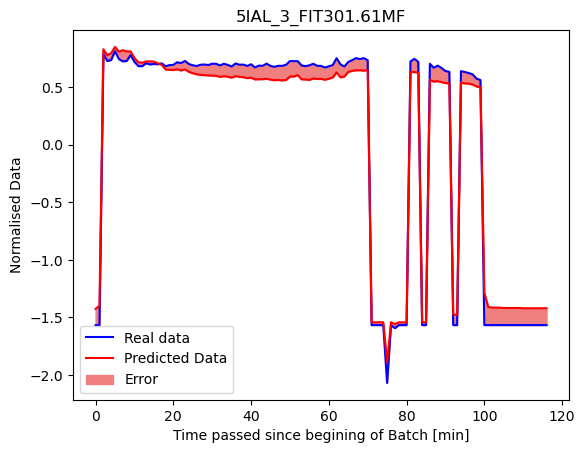

In [17]:
Random_Batch=Test_Grouped.get_group(random.sample(Test_Batches,1)[0])



Random_Batch=Random_Batch.drop(['5IAL_3_301.BatchName'],axis=1)
Random_Batch=np.expand_dims(Random_Batch,axis=2)
Random_Batch=np.expand_dims(Random_Batch,axis=3)


Random_Batch_Pred= model.predict(Random_Batch)

var=5   # 2=PIT 55, 5= MF

plt.plot(Random_Batch[:,var,0,0])
plt.plot(Random_Batch_Pred[:,var,0,0])
plt.legend(['Real data','Predicted Data'])
plt.xlabel('Time passed since begining of Batch [min]')
plt.ylabel('Normalised Data')
plt.title(data_norm.columns[var])
plt.figure()

plt.plot(Random_Batch[:,var,0,0],'b')
plt.plot(Random_Batch_Pred[:,var,0,0],'r')
plt.fill_between(np.arange(Random_Batch.shape[0]), Random_Batch_Pred[:,var,0,0], Random_Batch[:,var,0,0], color='lightcoral')
plt.legend(labels=['Real data','Predicted Data', "Error"])
plt.xlabel('Time passed since begining of Batch [min]')
plt.ylabel('Normalised Data')
plt.title(data_norm.columns[var])

MAE=np.sum(np.abs(Random_Batch[:,var,0,0]-Random_Batch_Pred[:,var,0,0])/Random_Batch.shape[0])
print(MAE)

5/5 [==============================] - 0s 3ms/step
0.06703150761800292


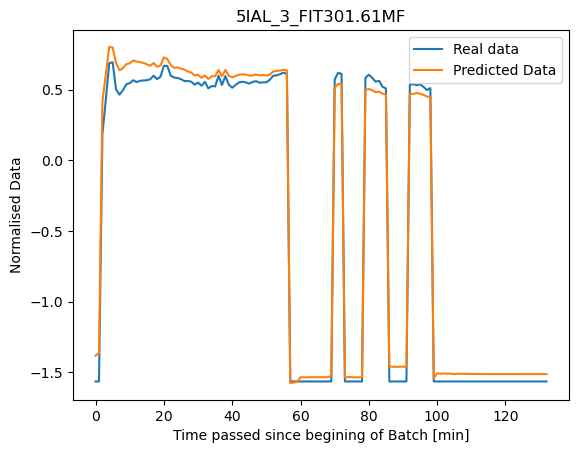

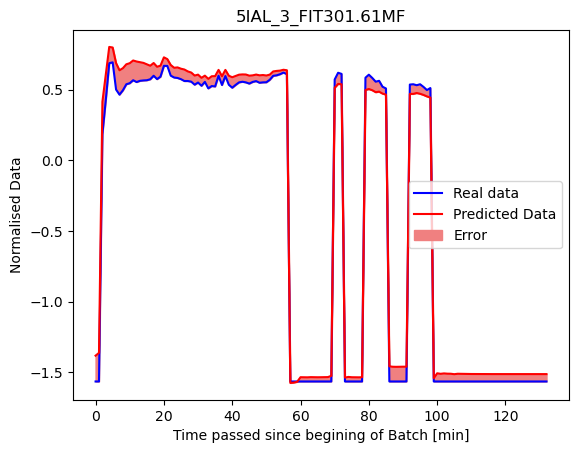

In [18]:
Random_Batch=Test_Grouped.get_group(Test_Batches[48])



Random_Batch=Random_Batch.drop(['5IAL_3_301.BatchName'],axis=1)
Random_Batch=np.expand_dims(Random_Batch,axis=2)
Random_Batch=np.expand_dims(Random_Batch,axis=3)


Random_Batch_Pred= model.predict(Random_Batch)

var=5   # 2=PIT 55, 5= MF

plt.plot(Random_Batch[:,var,0,0])
plt.plot(Random_Batch_Pred[:,var,0,0])
plt.legend(['Real data','Predicted Data'])
plt.xlabel('Time passed since begining of Batch [min]')
plt.ylabel('Normalised Data')
plt.title(data_norm.columns[var])
plt.figure()

plt.plot(Random_Batch[:,var,0,0],'b')
plt.plot(Random_Batch_Pred[:,var,0,0],'r')
plt.fill_between(np.arange(Random_Batch.shape[0]), Random_Batch_Pred[:,var,0,0], Random_Batch[:,var,0,0], color='lightcoral')
plt.legend(labels=['Real data','Predicted Data', "Error"])
plt.xlabel('Time passed since begining of Batch [min]')
plt.ylabel('Normalised Data')
plt.title(data_norm.columns[var])

MAE=np.sum(np.abs(Random_Batch[:,var,0,0]-Random_Batch_Pred[:,var,0,0])/Random_Batch.shape[0])
print(MAE)

0
1/1 [==============================] - 0s 20ms/step
0.16570827932420465
1
4/4 [==============================] - 0s 3ms/step
0.10565181935442816
2
4/4 [==============================] - 0s 2ms/step
0.11445145986986544
3
3/3 [==============================] - 0s 3ms/step
0.08627215550491495
4
3/3 [==============================] - 0s 3ms/step
0.06053573700945991
5
3/3 [==============================] - 0s 3ms/step
0.5756702998401452
6
6/6 [==============================] - 0s 2ms/step
0.10101524769630726
7
6/6 [==============================] - 0s 2ms/step
0.060649846939488626
8
5/5 [==============================] - 0s 2ms/step
0.128164359001808
9
4/4 [==============================] - 0s 3ms/step
0.09316360368307192
10
4/4 [==============================] - 0s 3ms/step
0.08863332571663349
11
3/3 [==============================] - 0s 3ms/step
0.10255546499421182
12
3/3 [==============================] - 0s 3ms/step
0.07358215526588932
13
4/4 [==============================] - 0s 2ms/

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3/3 [==============================] - 0s 3ms/step
0.07252246477460755
23
4/4 [==============================] - 0s 3ms/step
0.026635735939409252
24
7/7 [==============================] - 0s 2ms/step
0.1497957628106863
25
3/3 [==============================] - 0s 3ms/step
0.08918013889124664
26
4/4 [==============================] - 0s 3ms/step
0.07442302170589393
27
5/5 [==============================] - 0s 2ms/step
0.05643721756871265
28
3/3 [==============================] - 0s 3ms/step
0.114369613997351
29
4/4 [==============================] - 0s 2ms/step
0.14520929698389815
30
4/4 [==============================] - 0s 3ms/step
0.0924643464615053
31
3/3 [==============================] - 0s 3ms/step
0.16997124777995737
32
3/3 [==============================] - 0s 3ms/step
0.13400899717132383
33
5/5 [==============================] - 0s 2ms/step
0.1197814712263345
34
5/5 [==============================] - 0s 2ms/step
0.0405568107821471
35
4/4 [==============================] - 0s 3

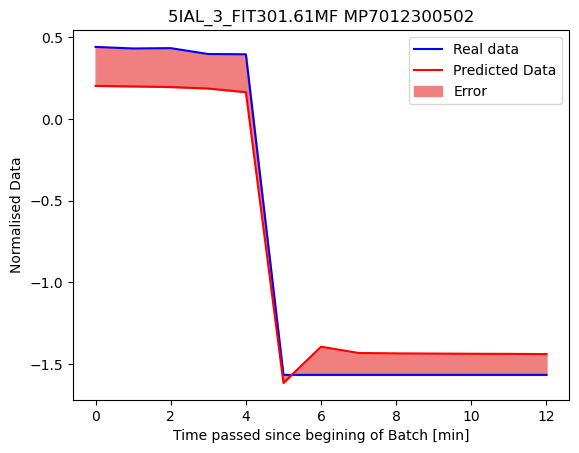

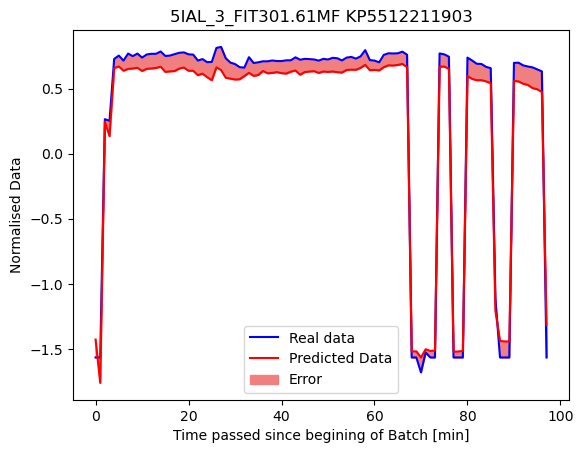

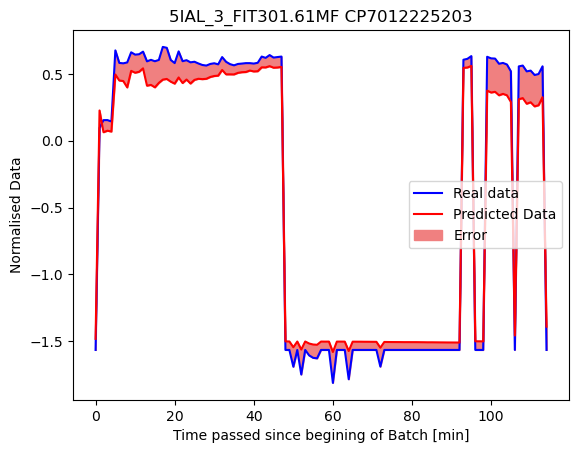

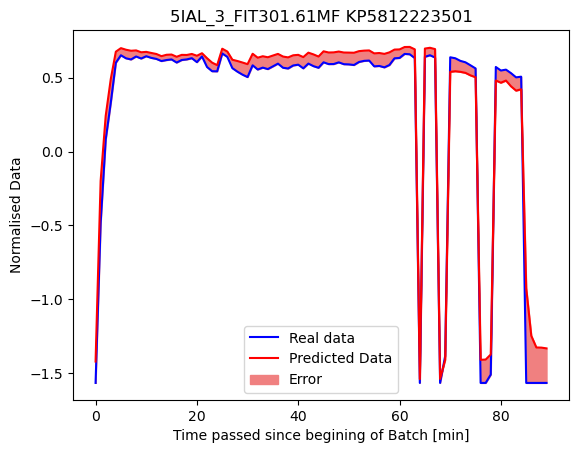

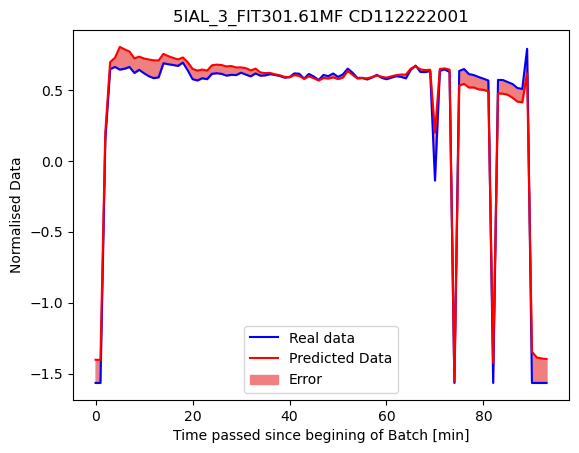

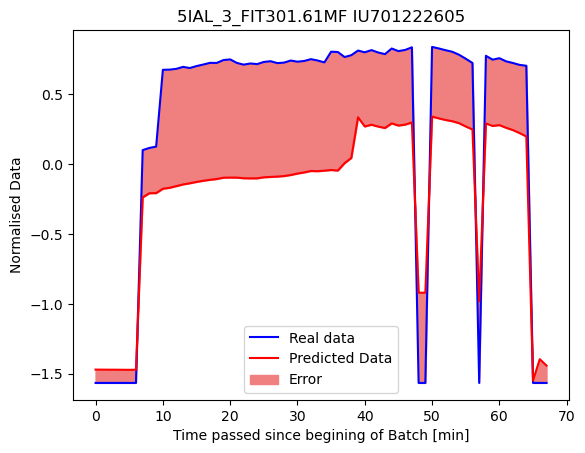

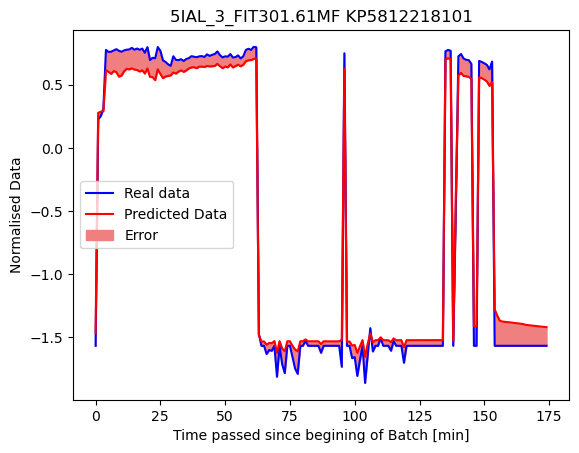

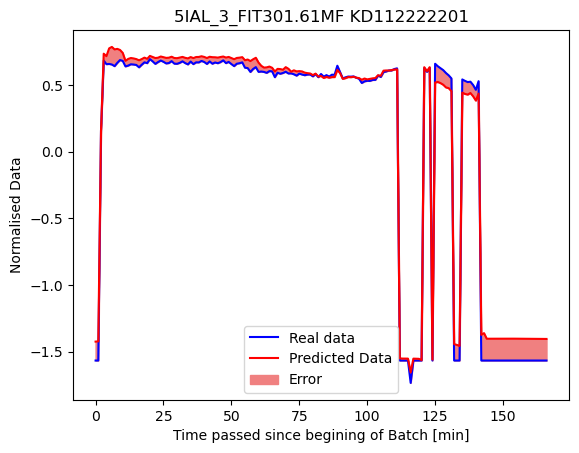

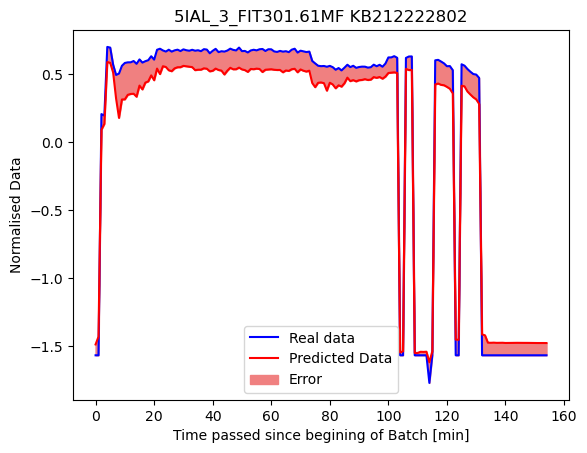

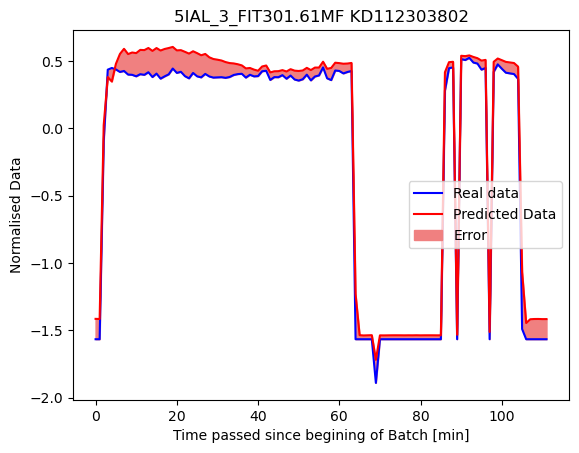

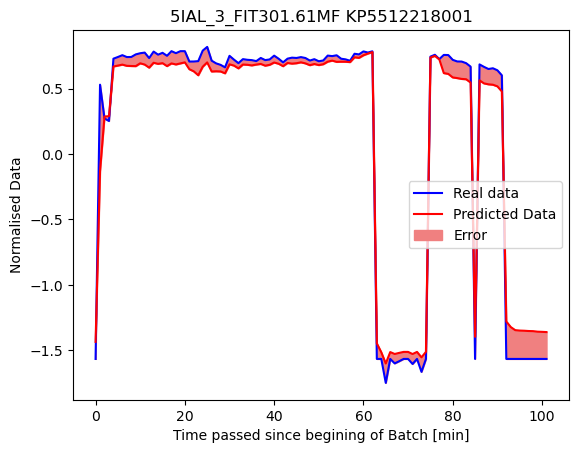

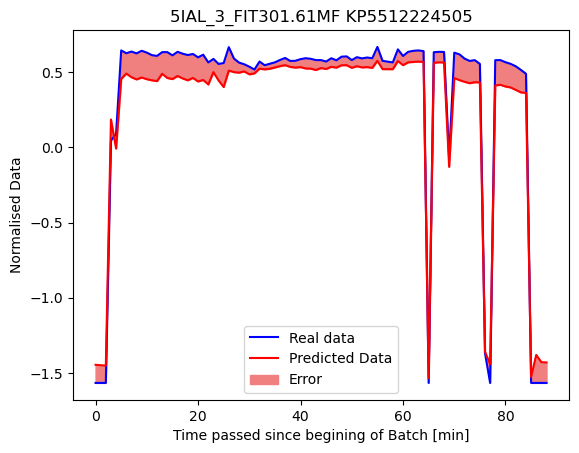

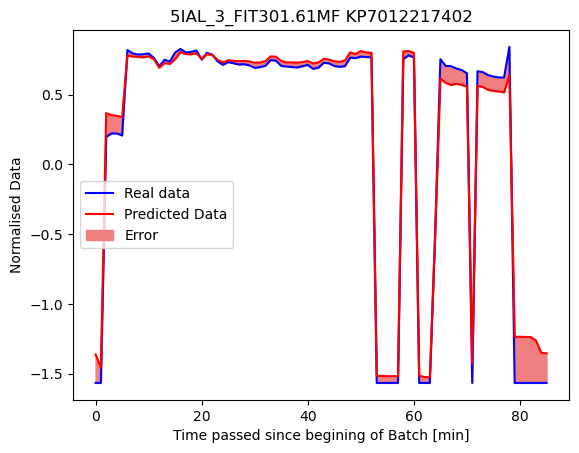

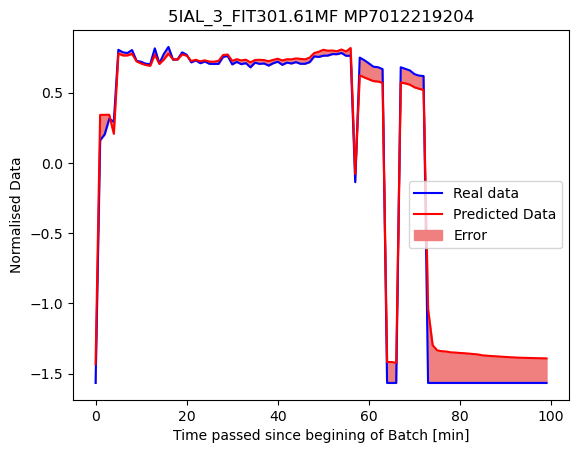

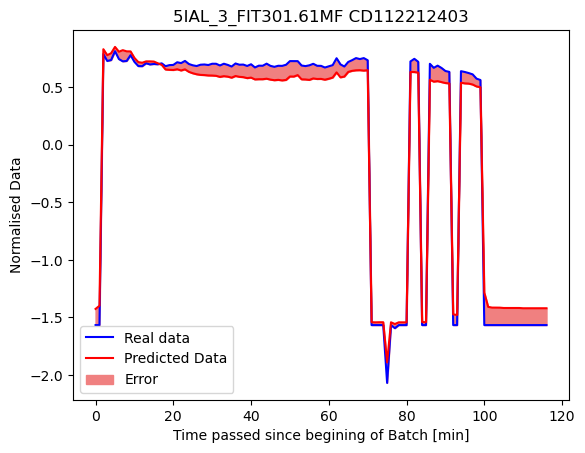

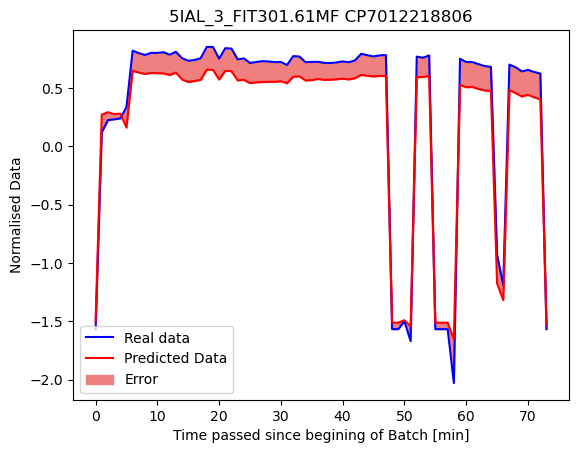

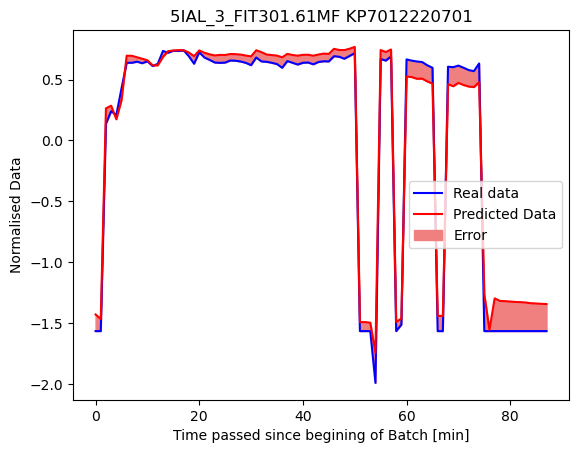

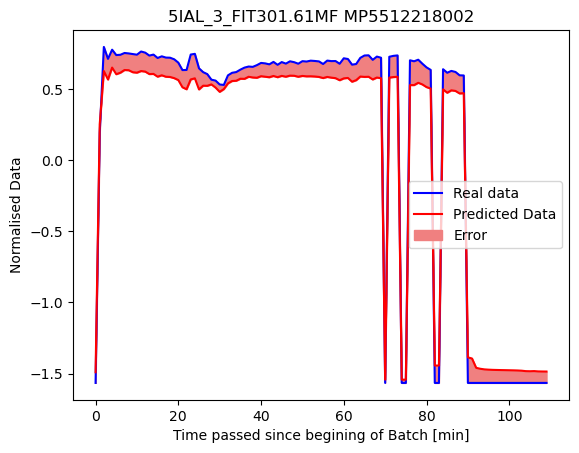

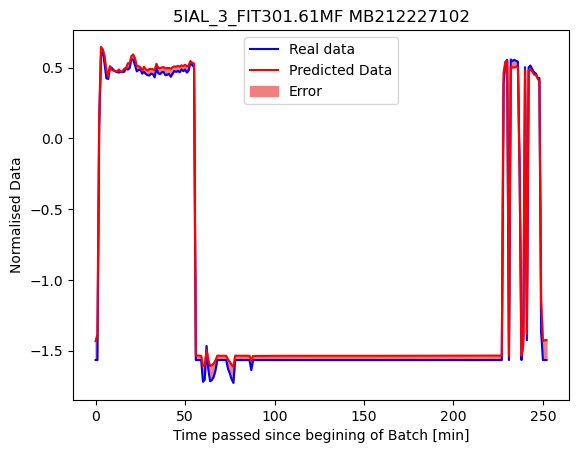

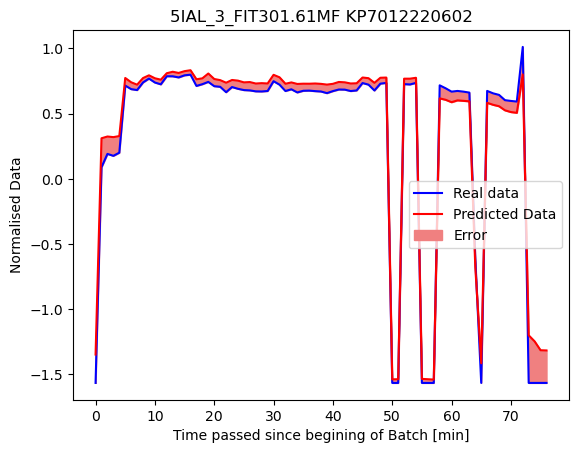

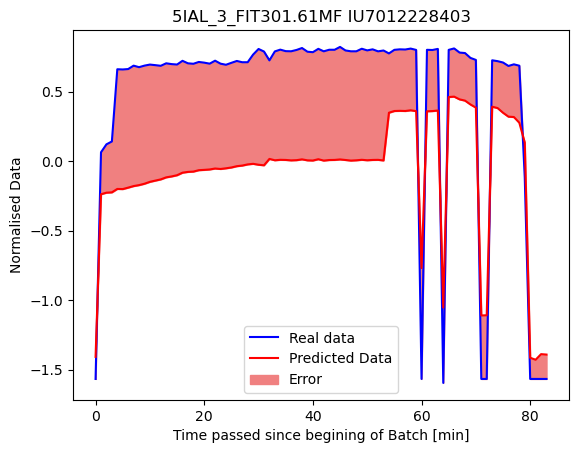

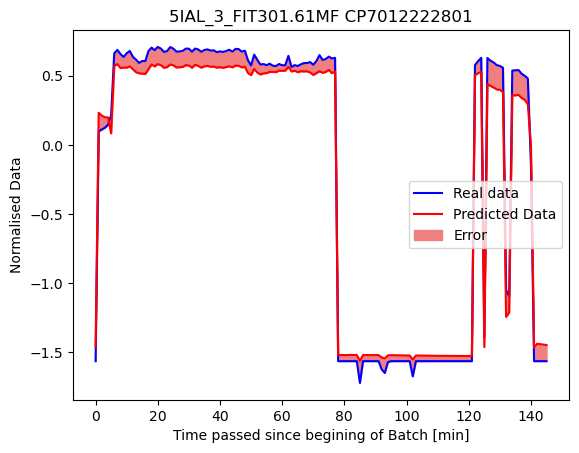

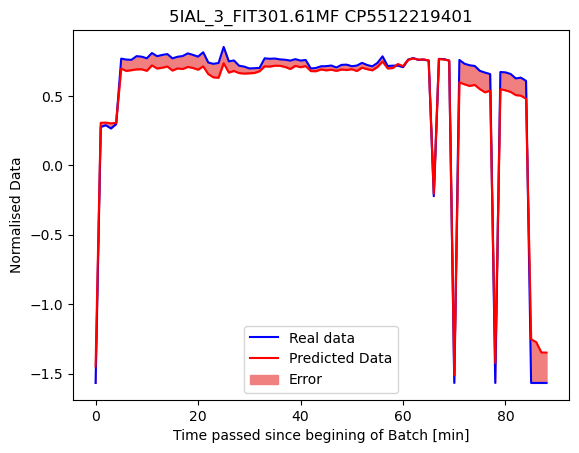

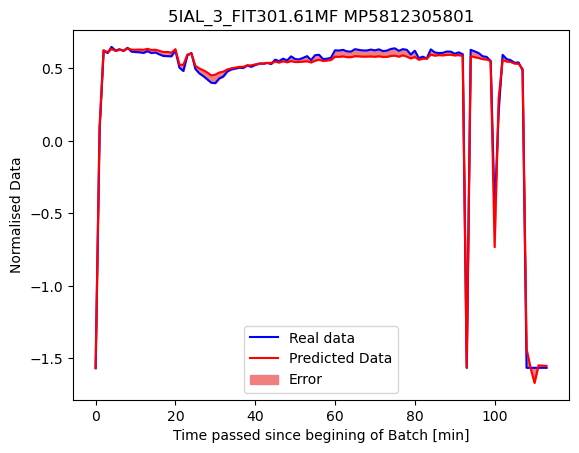

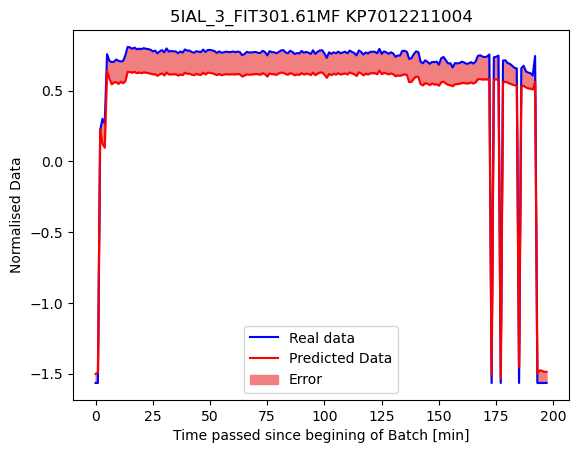

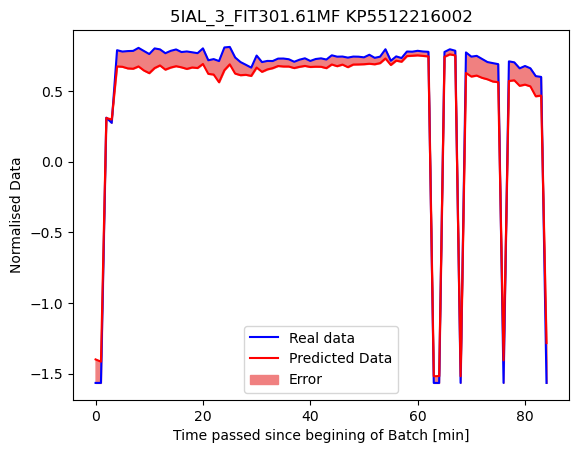

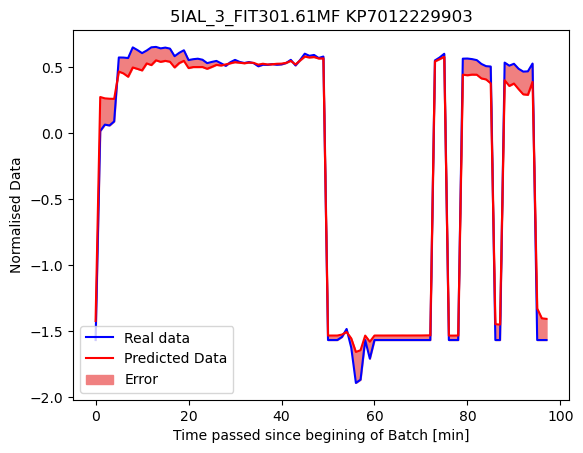

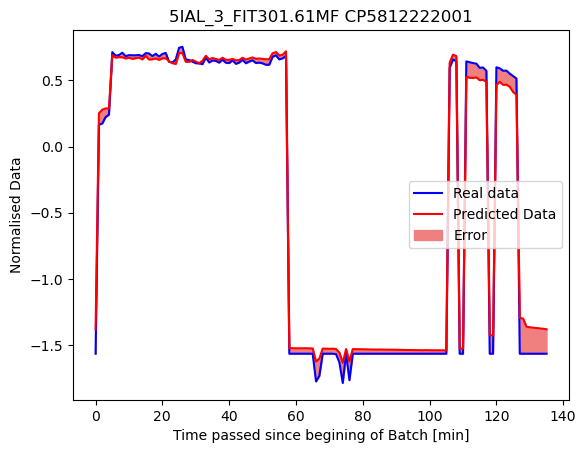

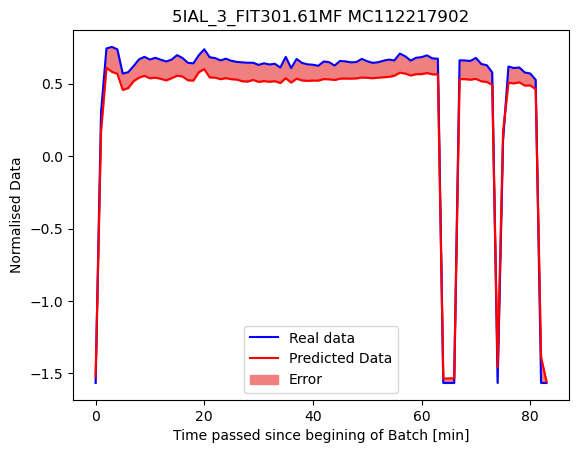

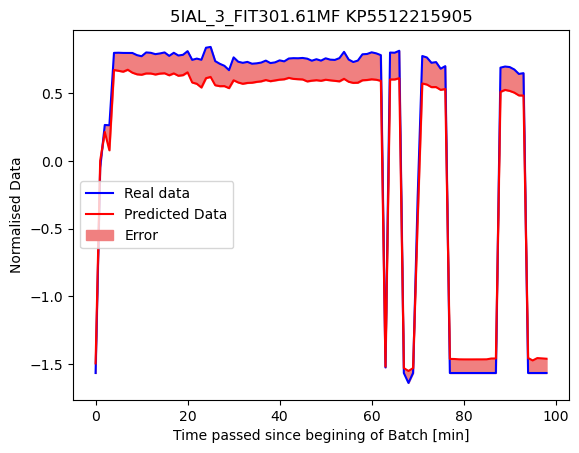

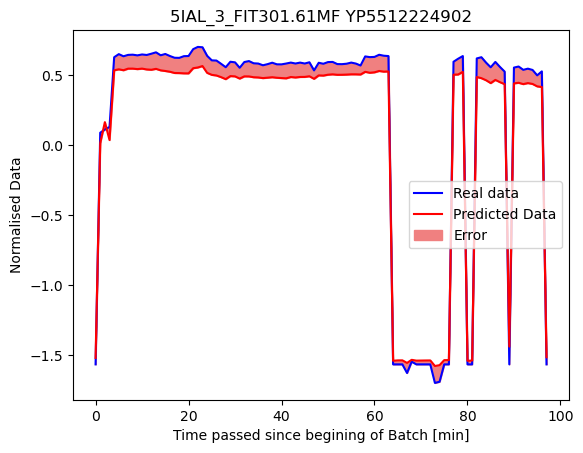

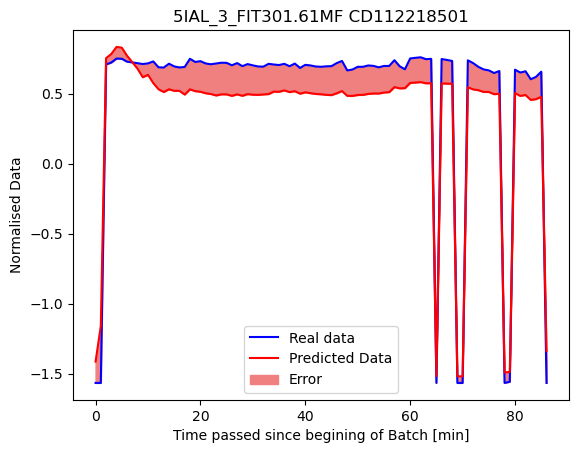

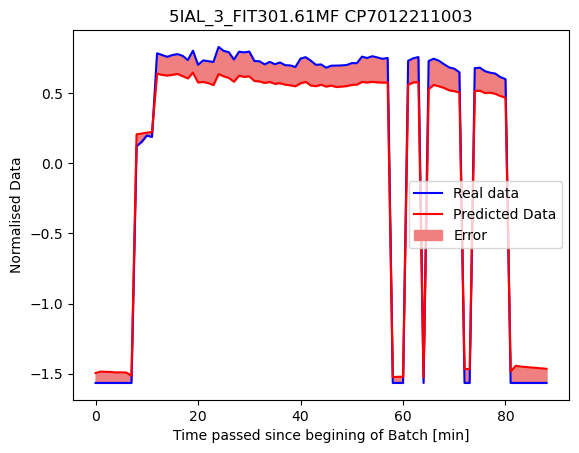

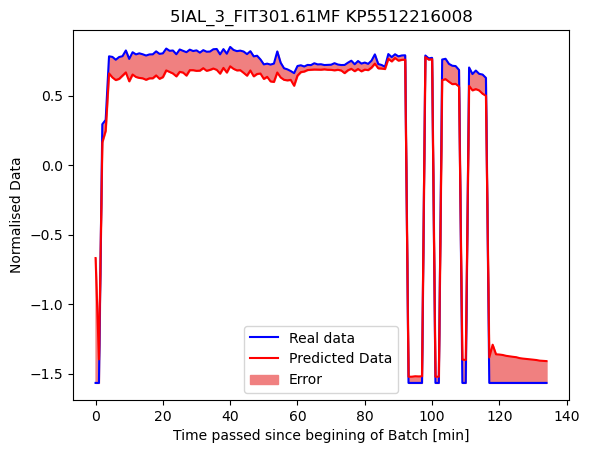

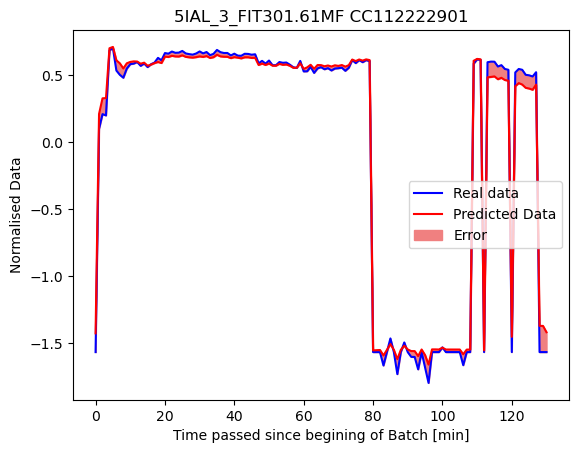

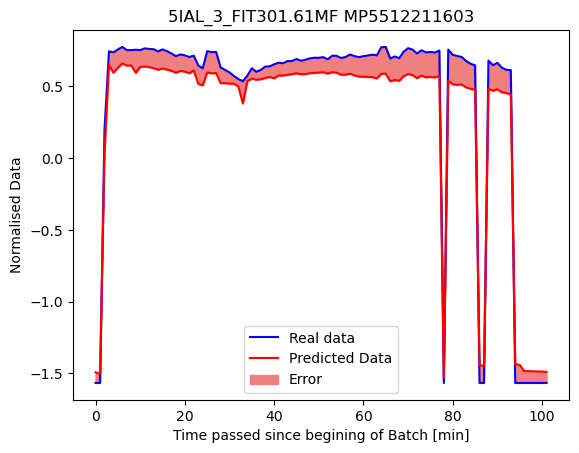

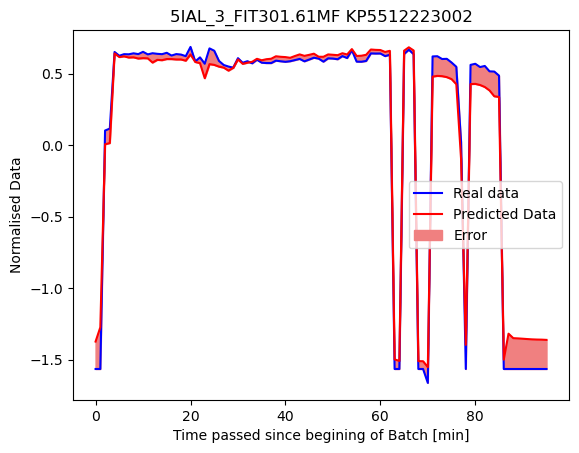

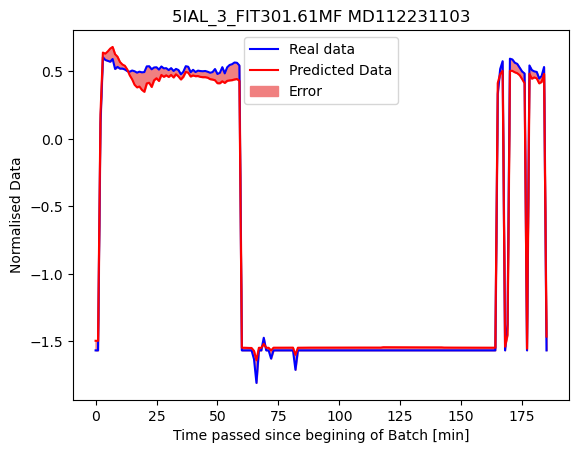

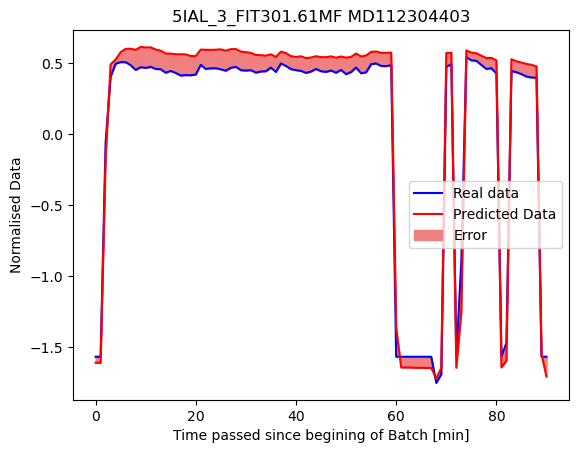

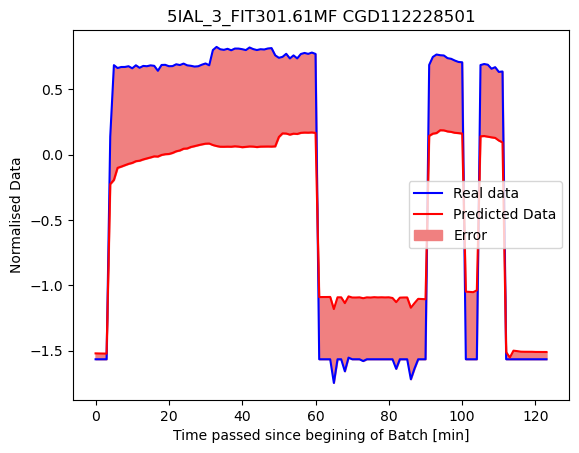

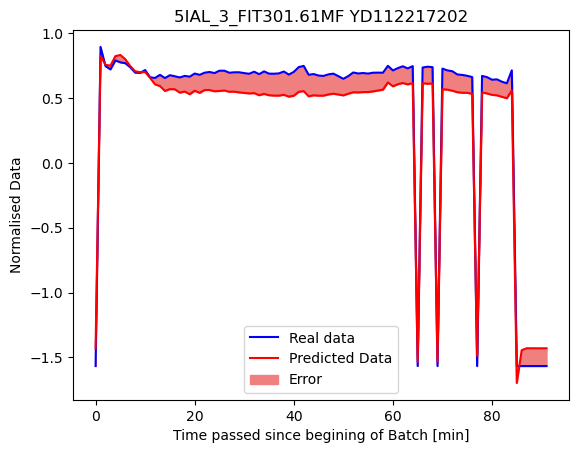

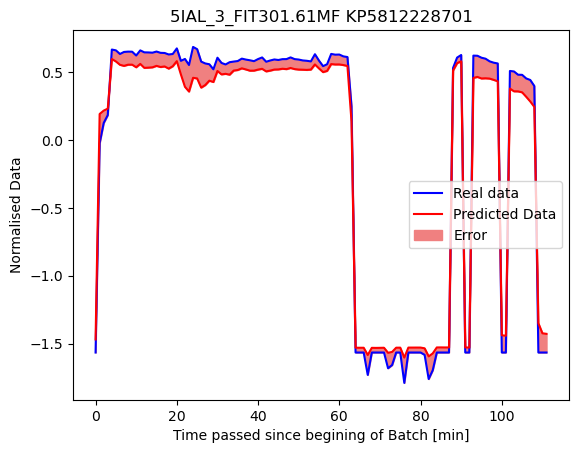

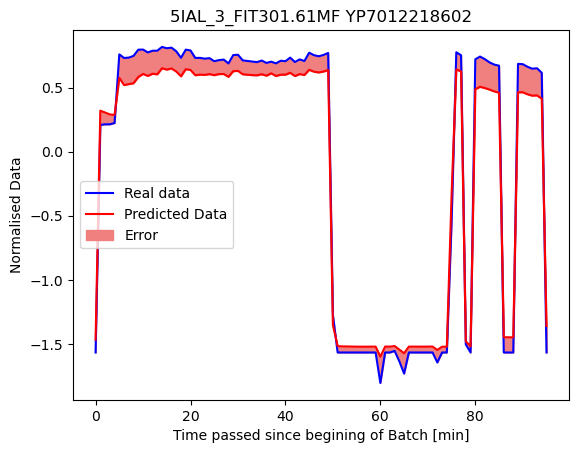

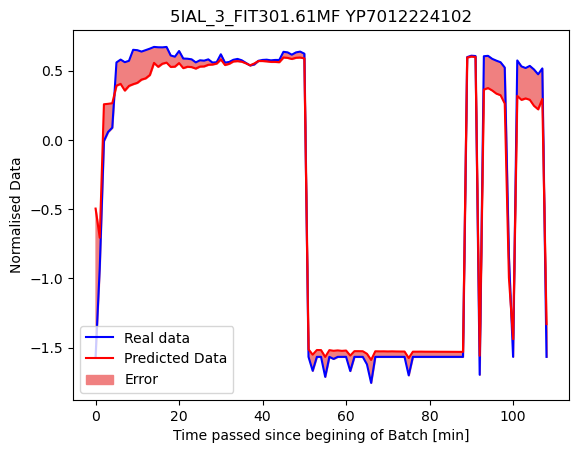

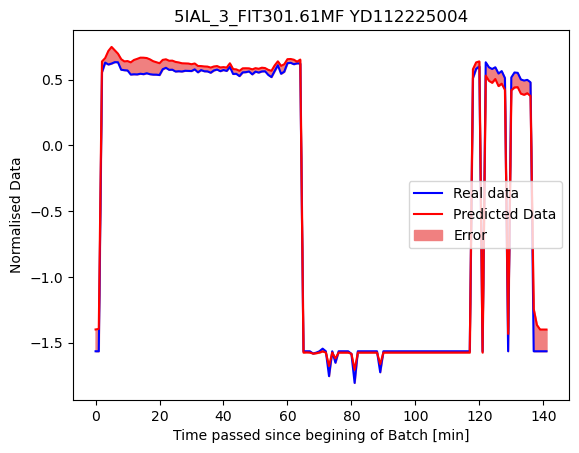

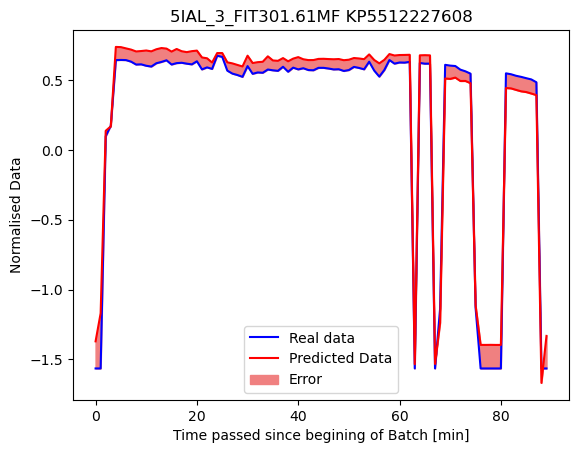

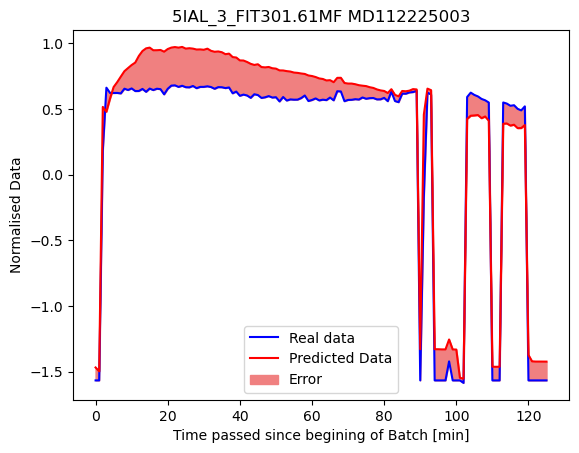

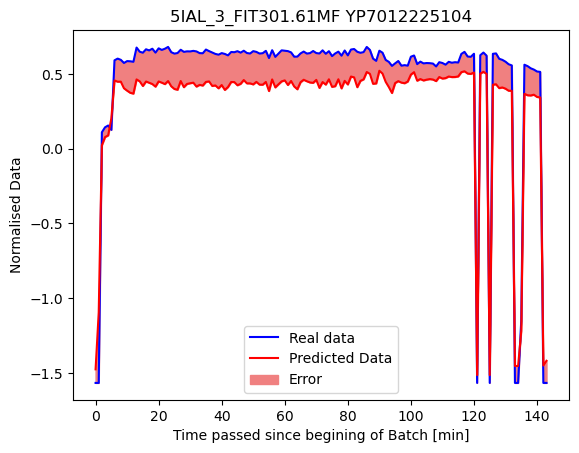

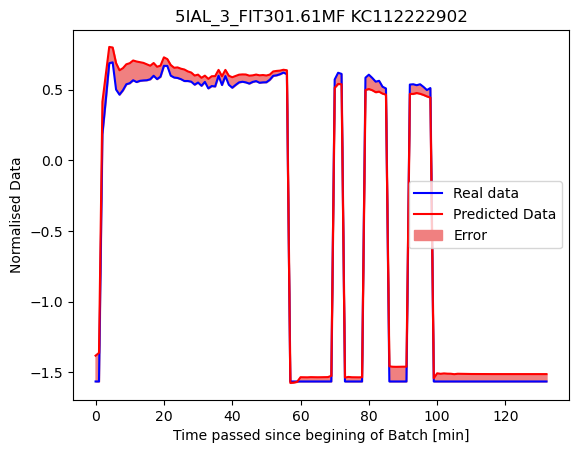

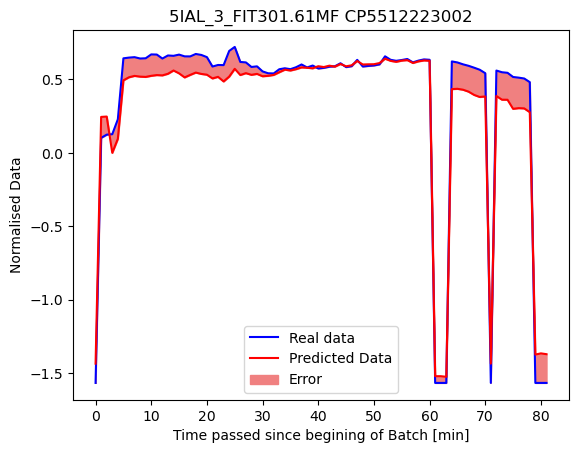

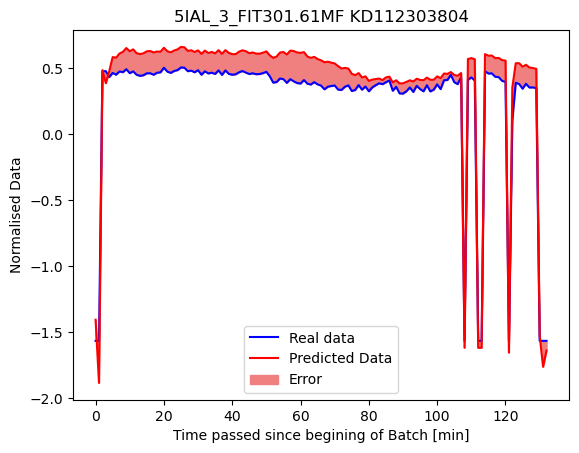

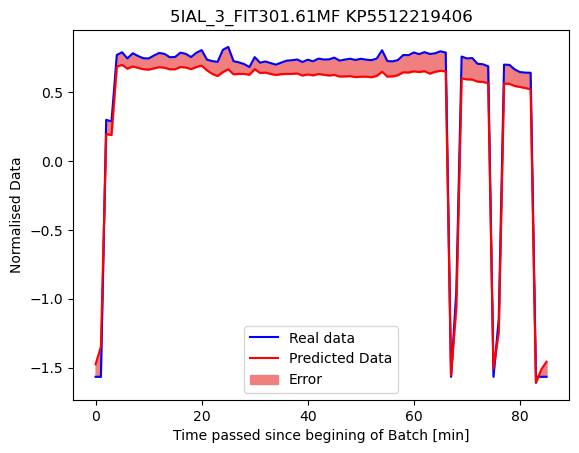

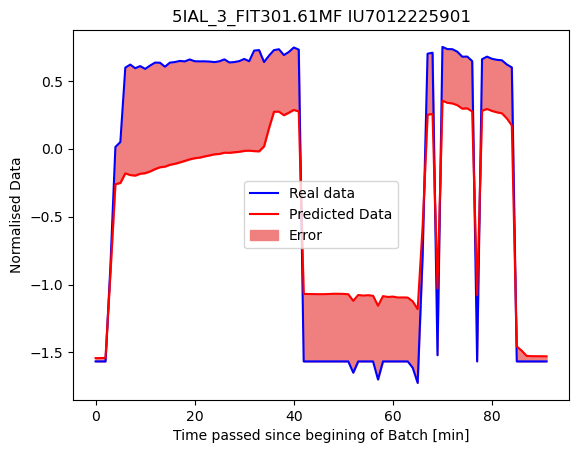

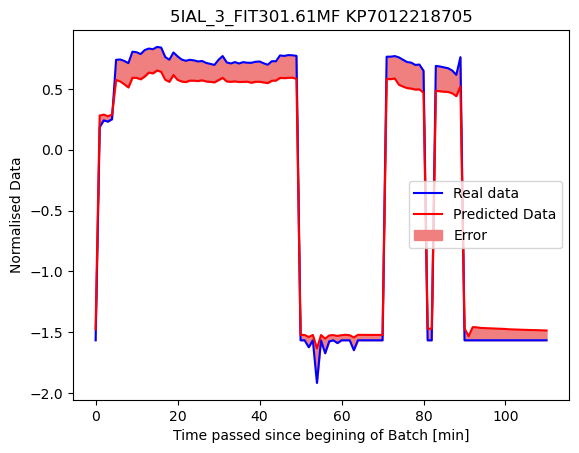

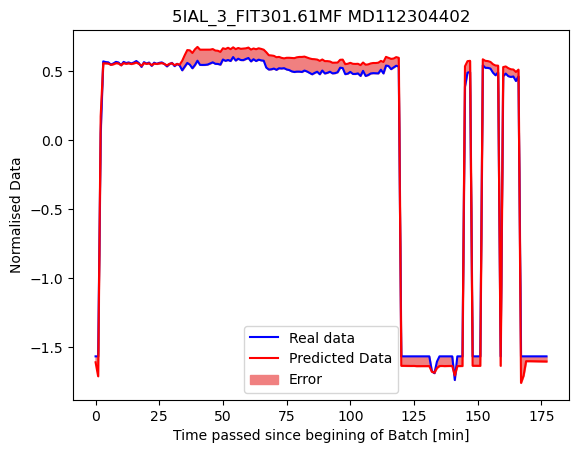

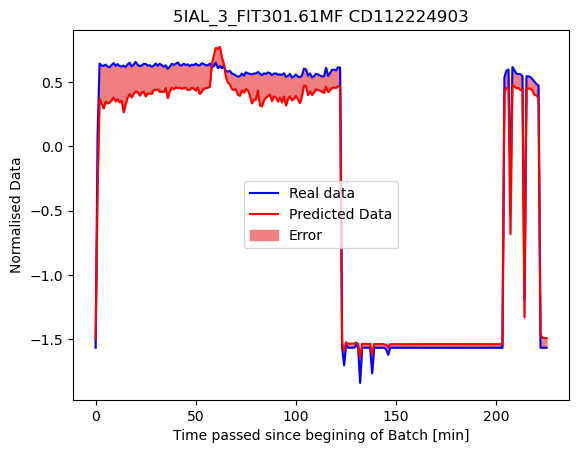

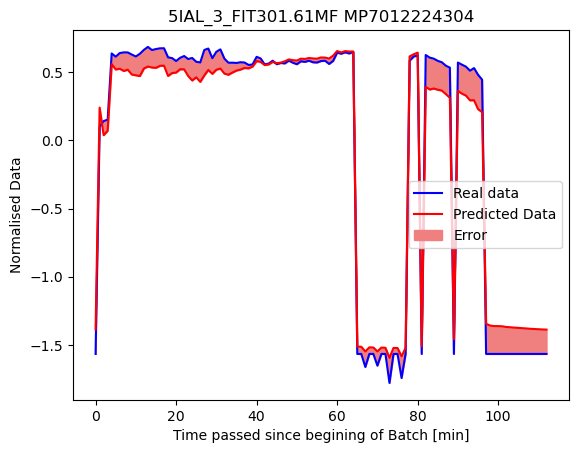

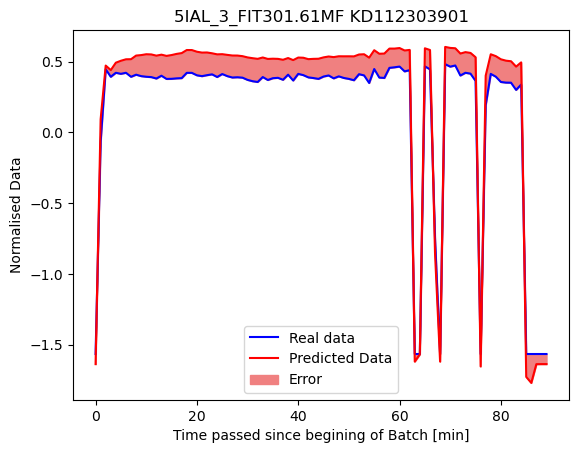

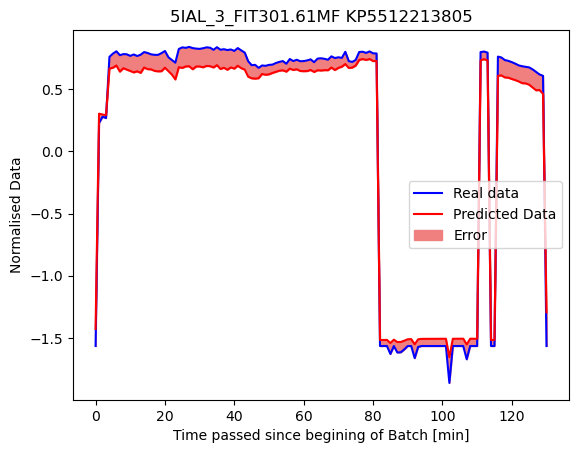

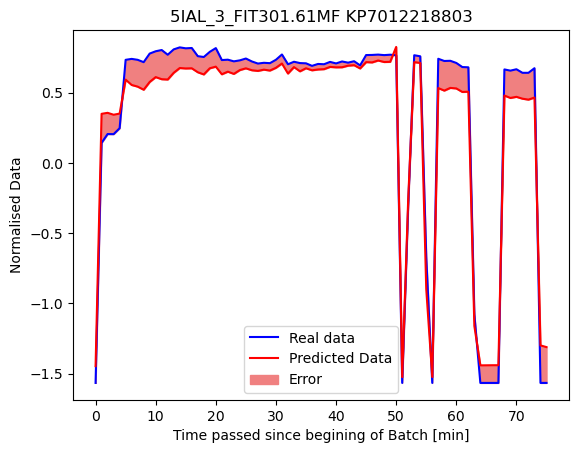

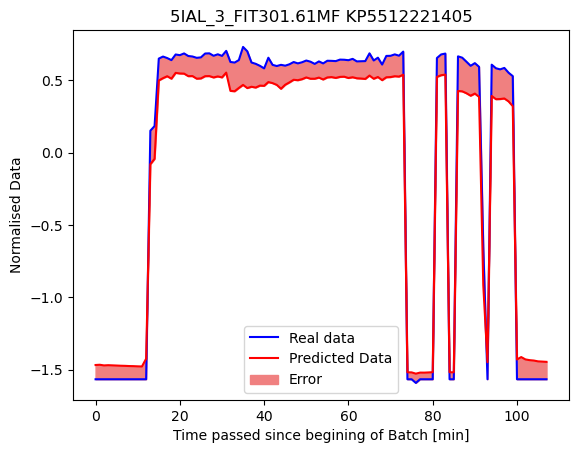

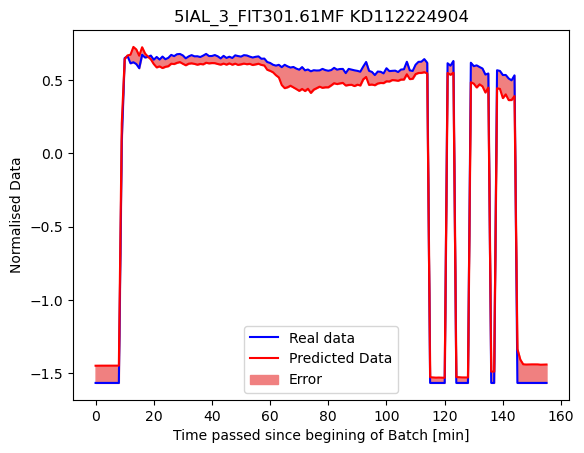

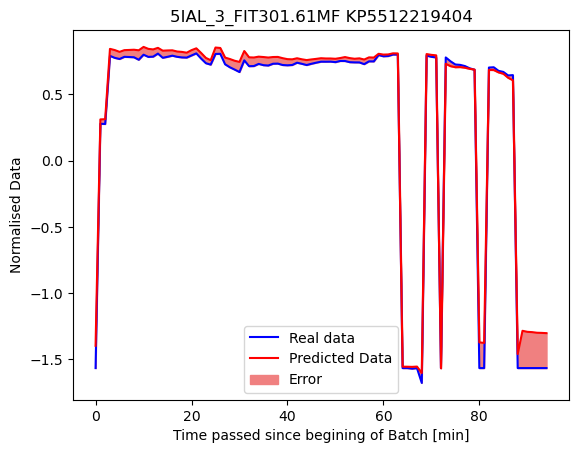

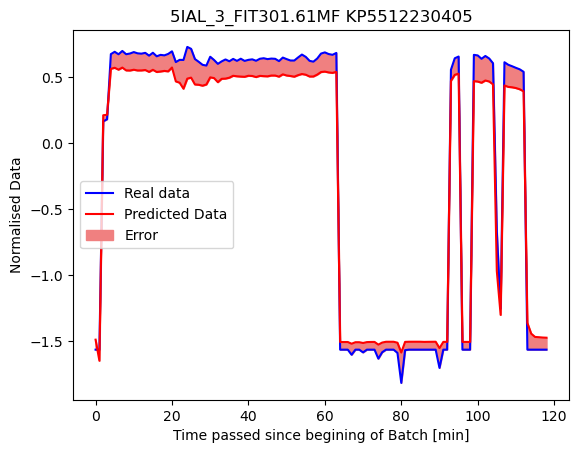

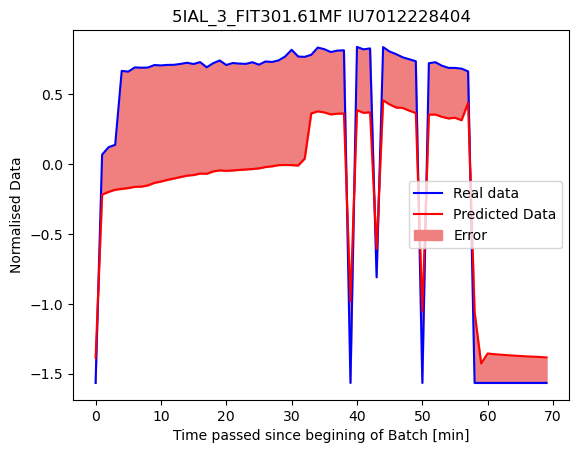

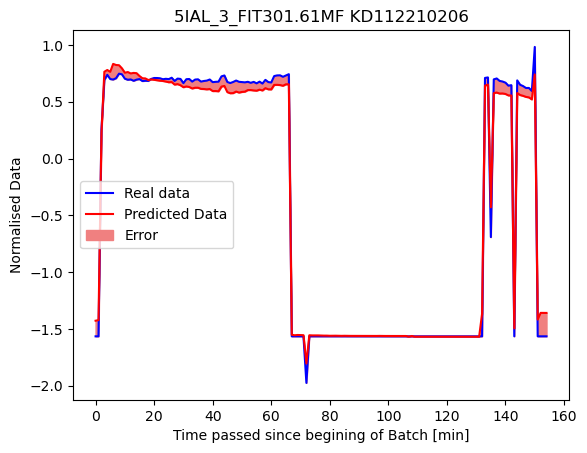

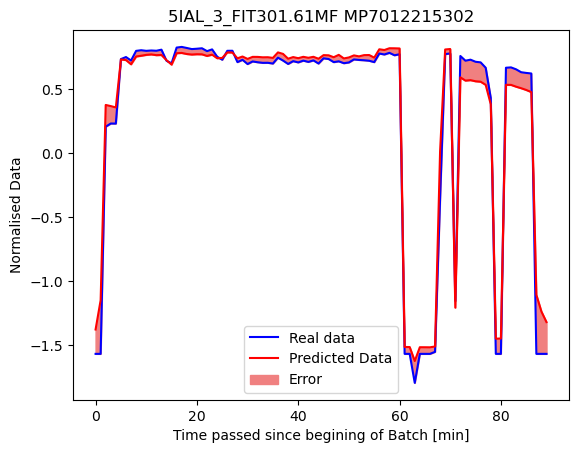

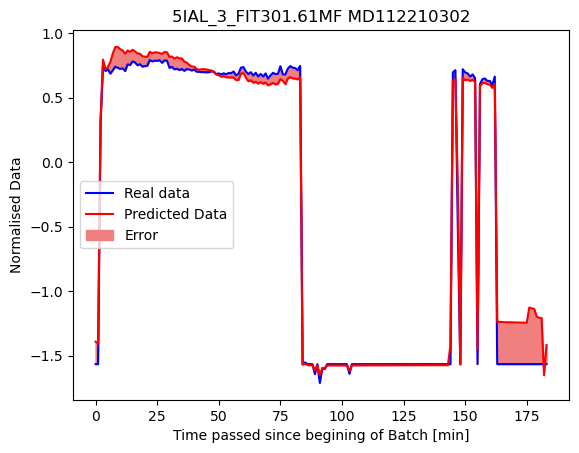

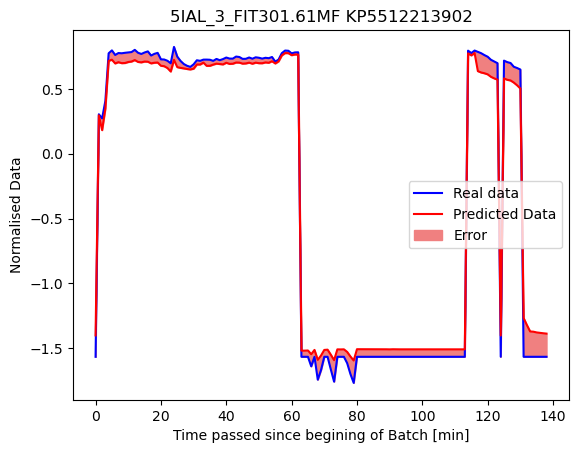

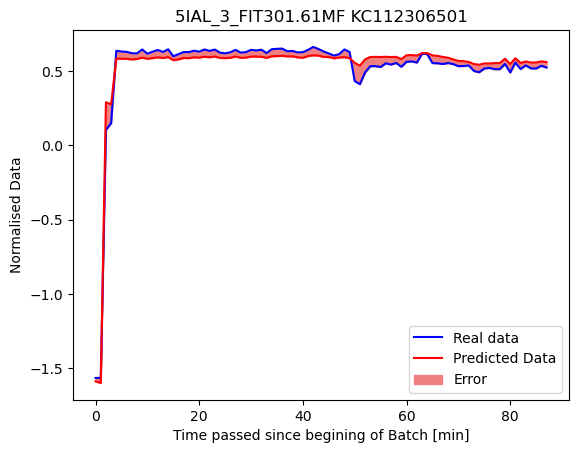

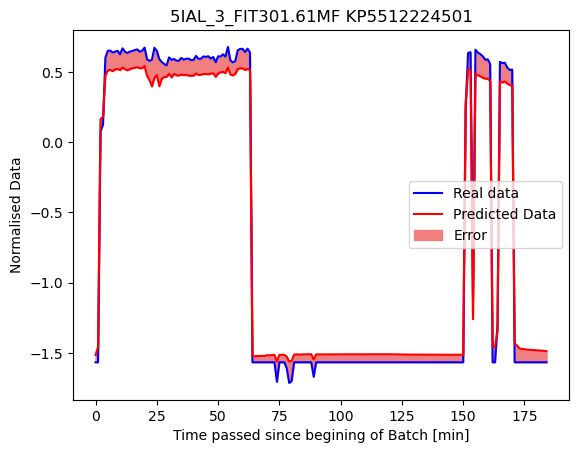

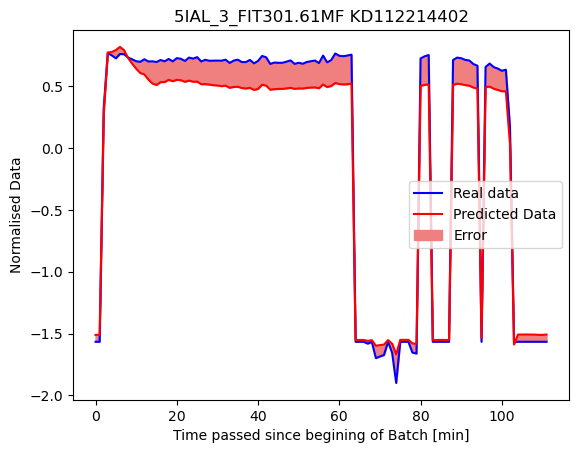

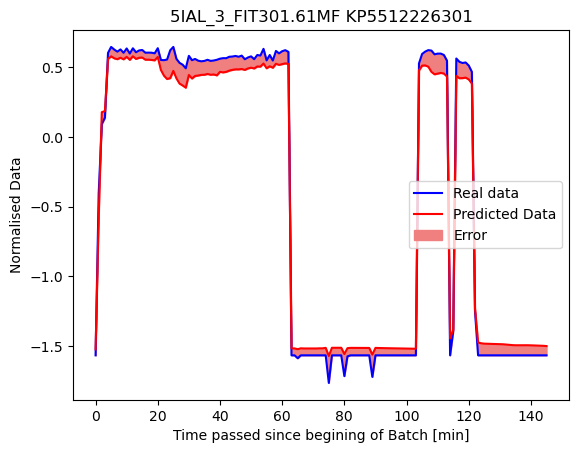

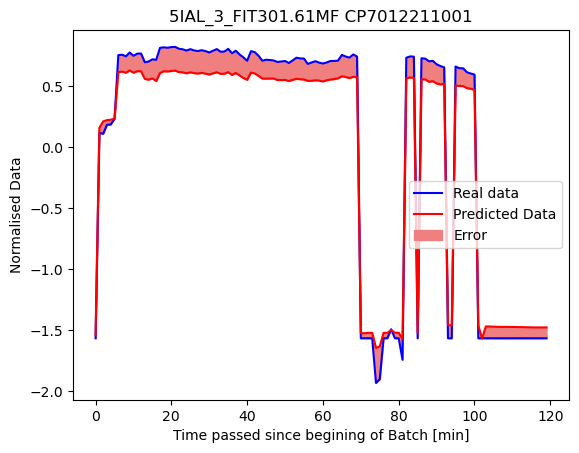

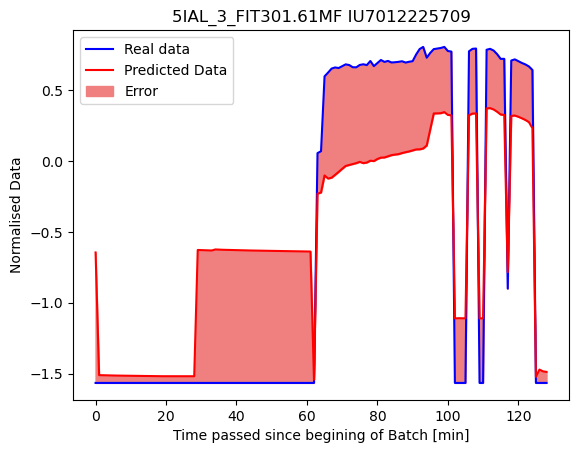

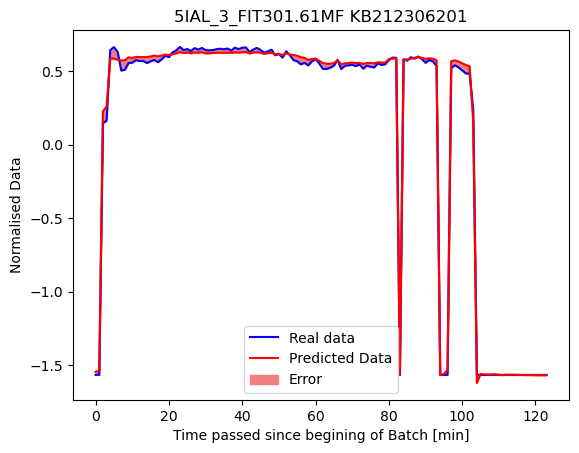

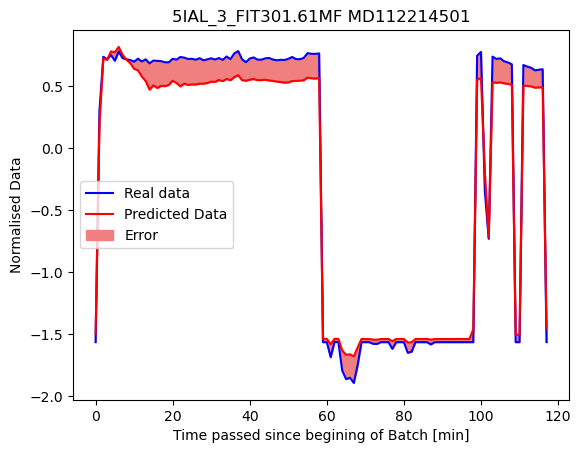

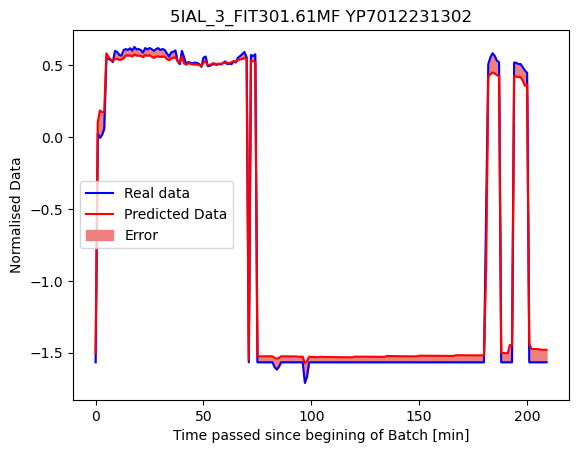

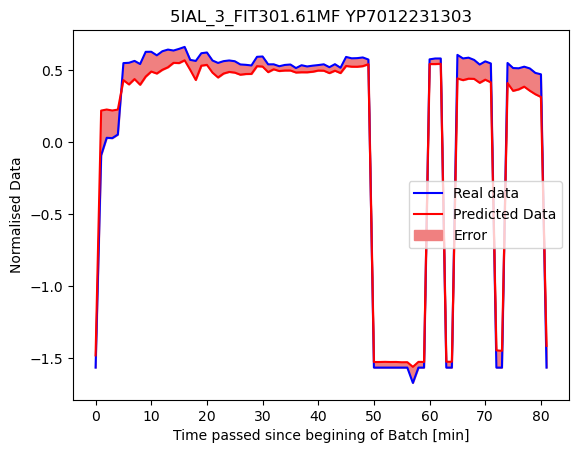

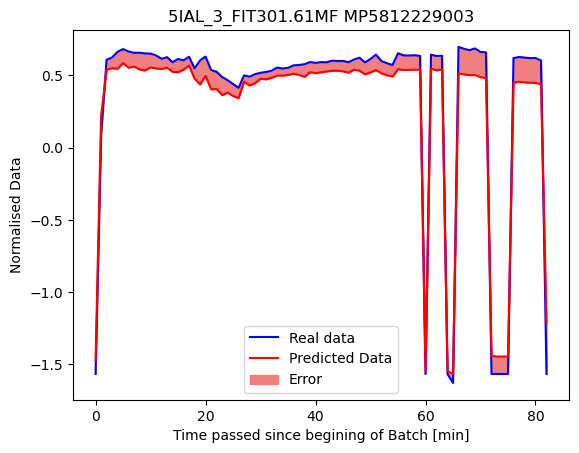

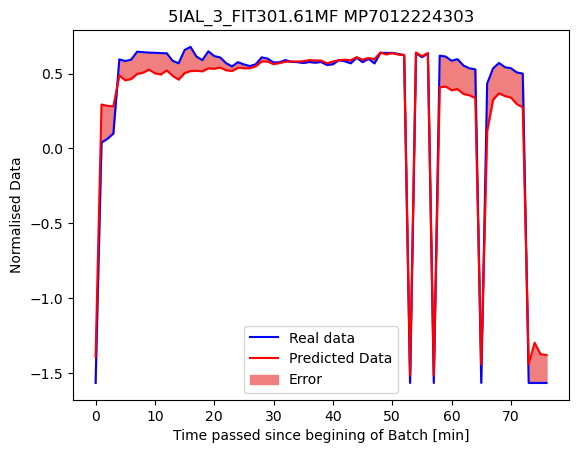

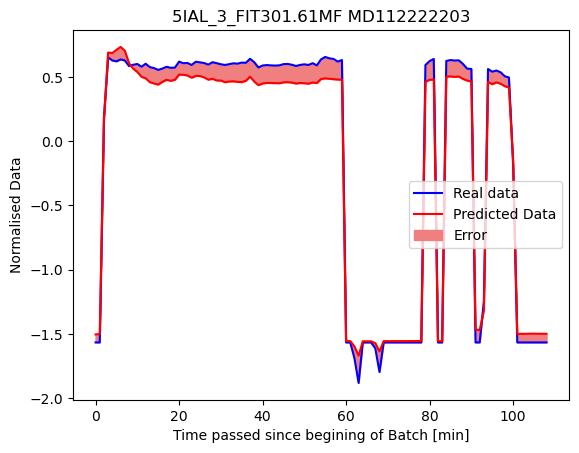

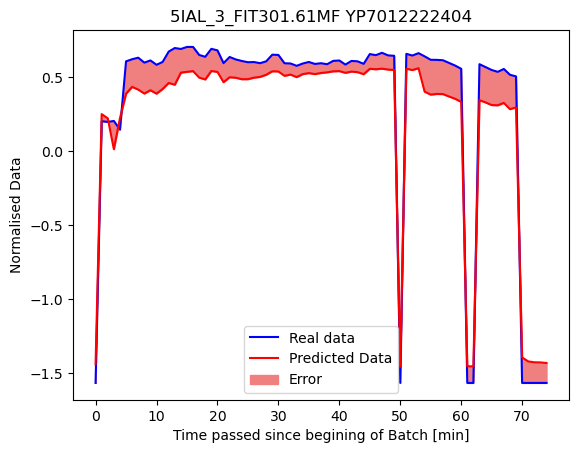

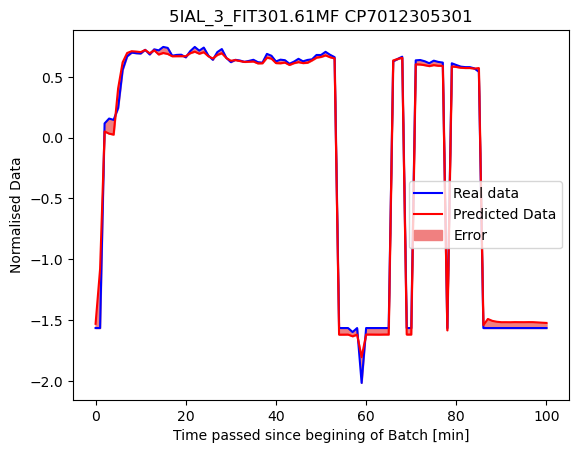

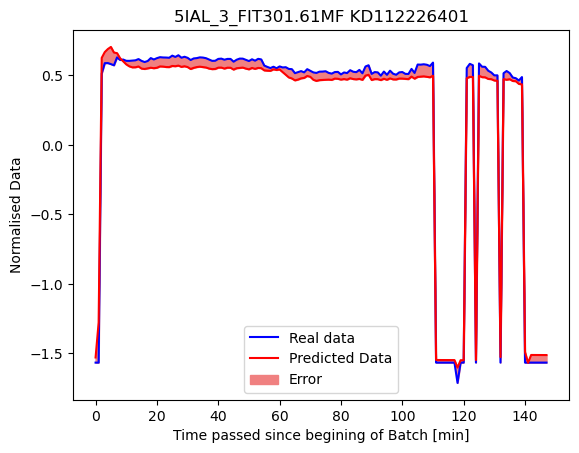

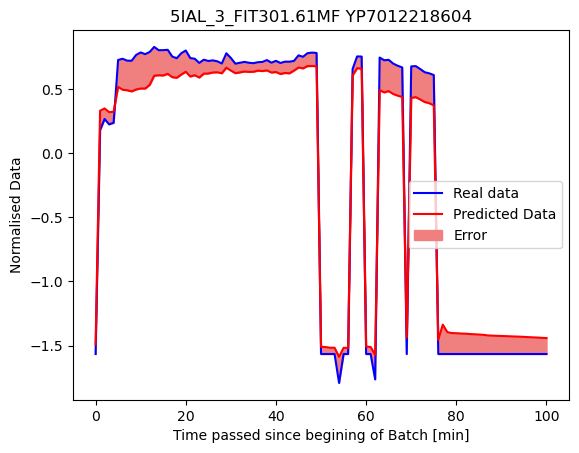

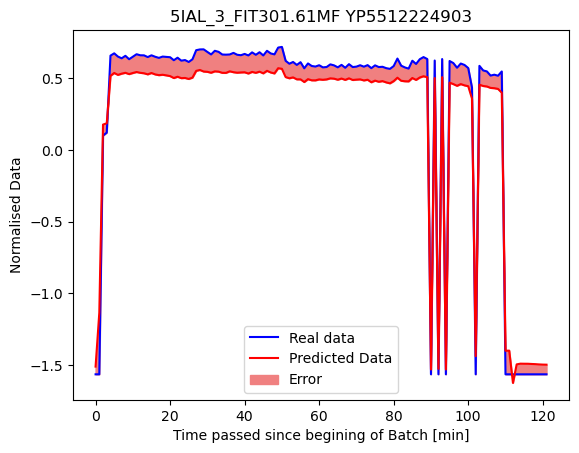

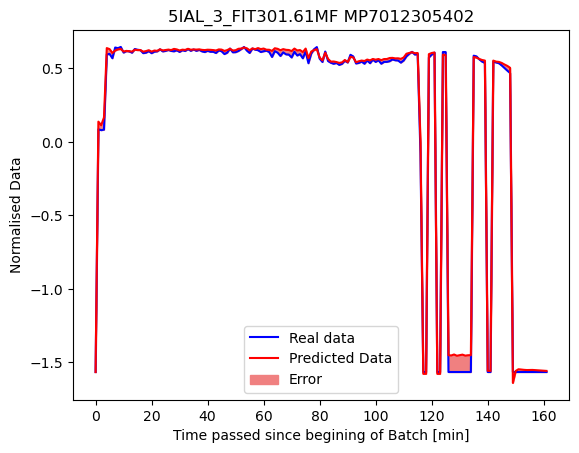

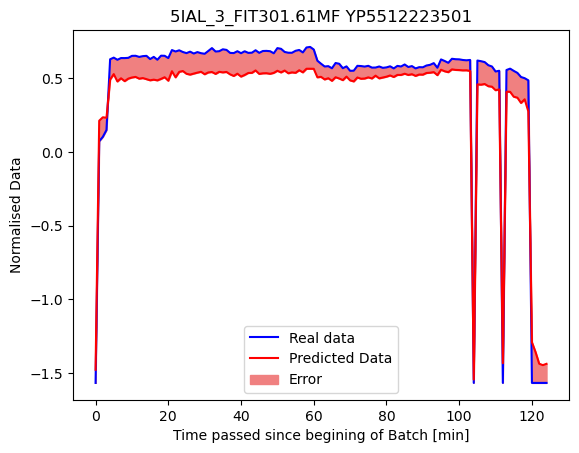

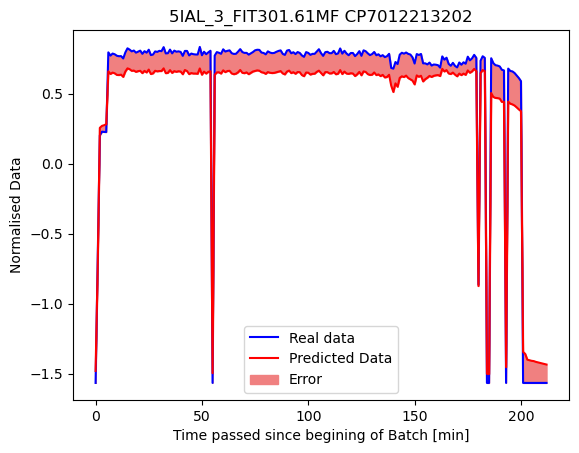

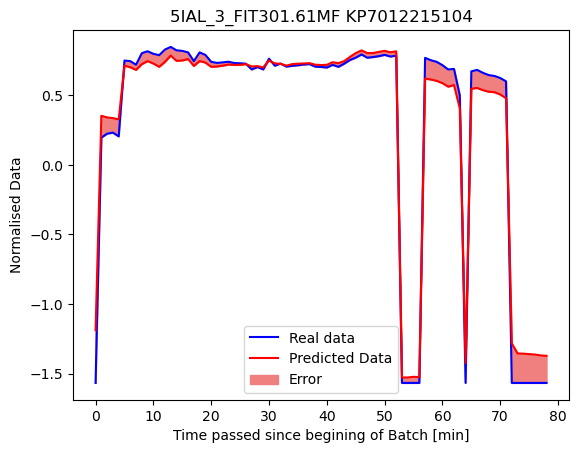

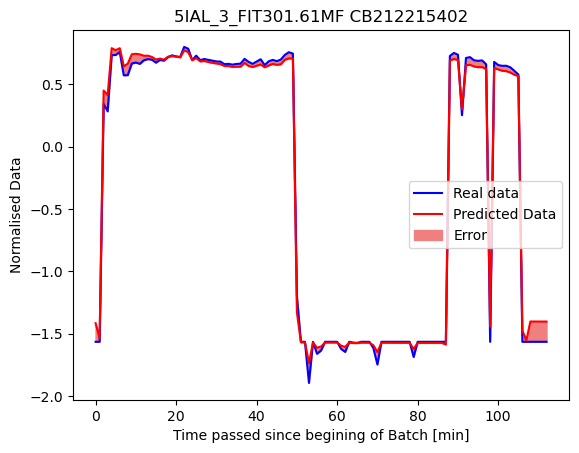

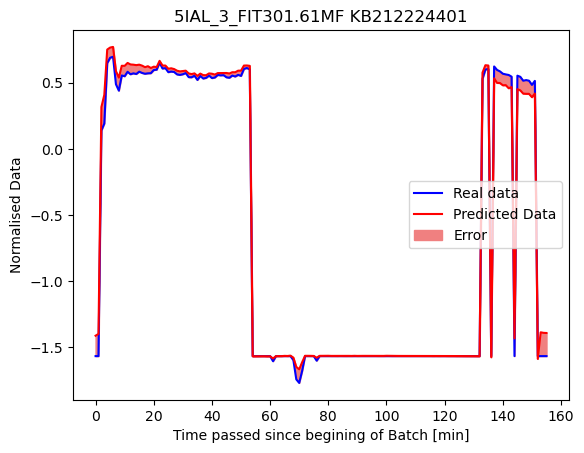

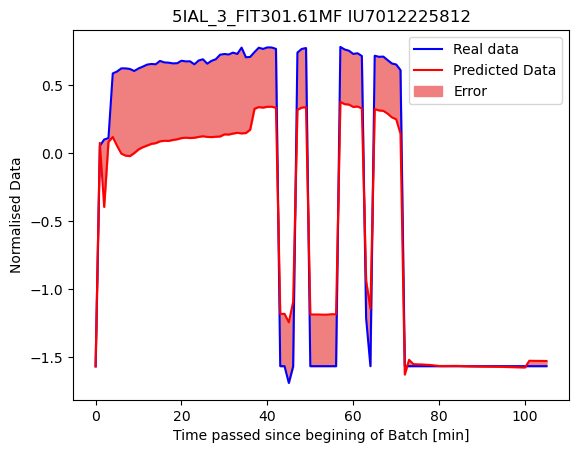

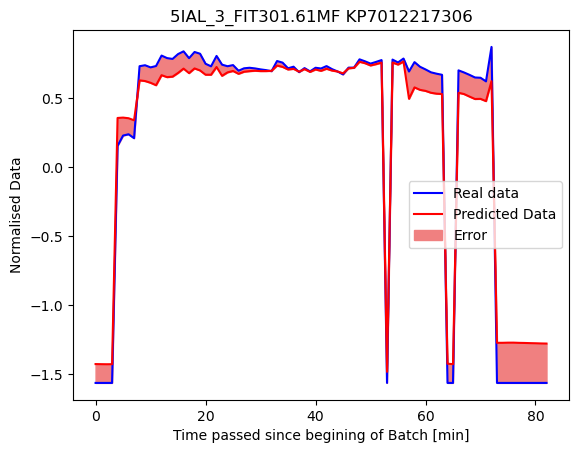

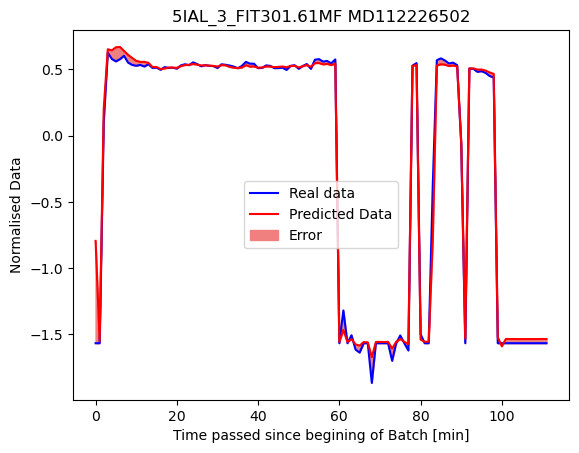

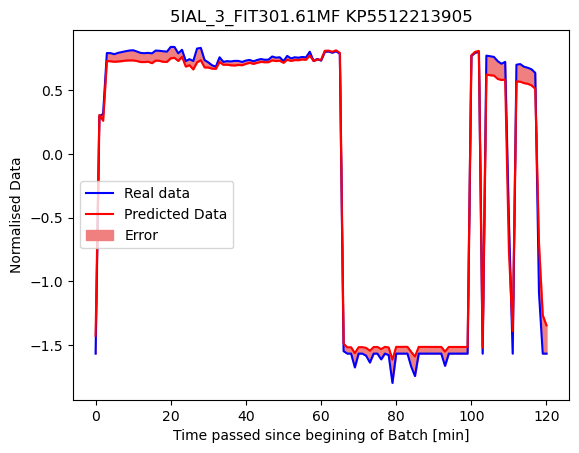

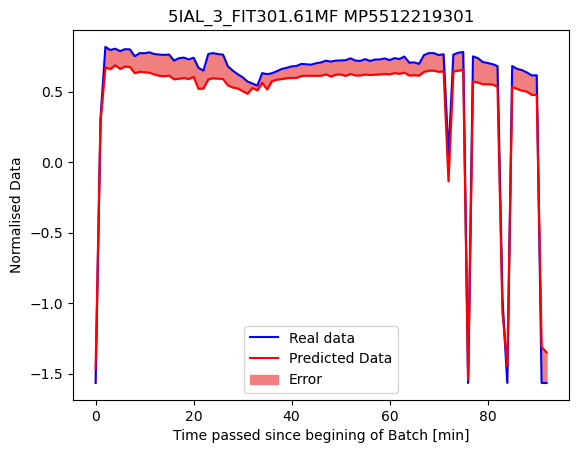

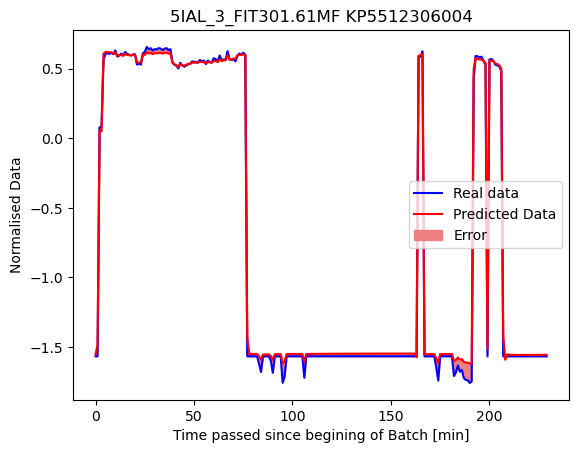

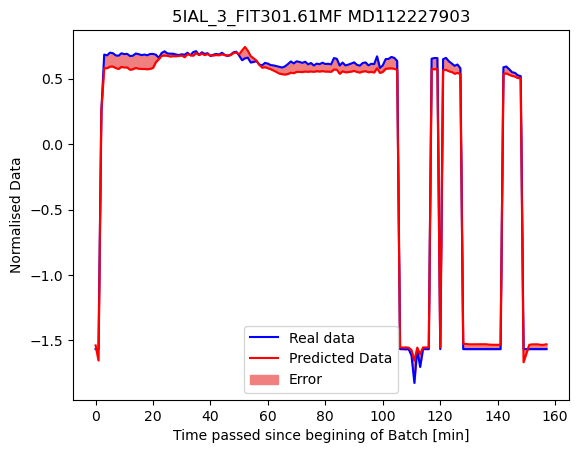

<Figure size 640x480 with 0 Axes>

In [19]:
MAE_arrea=[]

for i in range(100):
    print(i)
    Random_Batch=Test_Grouped.get_group(Test_Batches[i])

    Random_Batch=Random_Batch.drop(['5IAL_3_301.BatchName'],axis=1)
    Random_Batch=np.expand_dims(Random_Batch,axis=2)
    Random_Batch=np.expand_dims(Random_Batch,axis=3)


    Random_Batch_Pred= model.predict(Random_Batch)

    var=5   # 2=PIT 55, 5= MF

    plt.plot(Random_Batch[:,var,0,0],'b')
    plt.plot(Random_Batch_Pred[:,var,0,0],'r')
    plt.fill_between(np.arange(Random_Batch.shape[0]), Random_Batch_Pred[:,var,0,0], Random_Batch[:,var,0,0], color='lightcoral')
    plt.legend(labels=['Real data','Predicted Data', "Error"])
    plt.xlabel('Time passed since begining of Batch [min]')
    plt.ylabel('Normalised Data')
    plt.title(data_norm.columns[var] + ' ' + Test_Batches[i])
    plt.figure()

    MAE=np.sum(np.abs(Random_Batch[:,var,0,0]-Random_Batch_Pred[:,var,0,0])/Random_Batch.shape[0])
    print(MAE)
    MAE_arrea.append(MAE)

0.12335378575624394


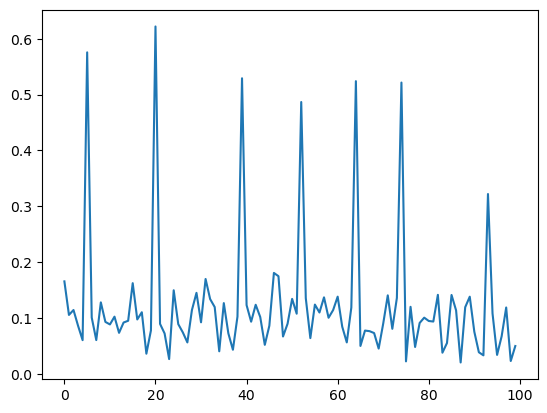

In [20]:
plt.plot(MAE_arrea)
print(np.mean(MAE_arrea))